In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import os
import re
import yaml
import sys
import subprocess
import math
import glob
import time
import random
from statistics import mean

from Astra import Astra
from settingsFile import SettingsFile

# Parallel focusing 
This is python code written in jupyter notebook which implements different methods for point-point to parallel-parallel focusing. It uses software ASTRA, a program to simulate beam dynamics in accelerators. Programs in this notebook run in the same directory as are the ASTRA executables, mainly generator and Astra. 

The initial information are regarding the input file to Astra and information about reference particles. I used 5 different reference particles to determine the focusing properties of a setup- the first particle with 0 offset and 0 angle, moving along the z axis. This particle should not move in the transverse direction. Next 2 particles would be with initial offsets in the x and y directions respectively, but because this is point-point focusing, I am not using these. Last 2 have angles in the x and y direction respectively.

The magnets that are used are permanent quadrupole magnets with set gradients, lengths and bore diameters. These parameters can be changed, but for now they are set to values of 3 quadrupole magnets in LLR laboratory. The variables which will be changing are distances between them and the initial momentum. D1 is the distance from the source to the 1. quadrupole magnet. Realistically, D1 is only up to fringe fields which are magnetic fields outside the magnet's bores (reach 3*bore size in ASTRA). This option can be changed using TopHatShapedQuads() function. D2 and D3 are distances between first 2 and last 2 magnets in sequence. Last variable that can be changed is the initial longitudinal momentum of particles.

For running beam simulations, one can define it's initial parameters like spread of transverse momenta, spread of longitudinal energy, spread of offsets in the x and y directions as well as in the longitudinal direction. Also number of initial particles, space charge, secondary particle emission or other parameters can be changed in file parallelBeam.in.


In [18]:
def function(D, D1, hardEnd,momZ, switch):

    #print(f"input D2, D3 = {D}")
    
    dataCurrent = astra.runRefHardEnd(D1,D[0], D[1], hardEnd, momZ , False)
    if dataCurrent == 1:
        return 1E+9
    
    if switch == "parallel":    
        sum = parallelFocusing(dataCurrent)
    elif switch == "point":
        sum = pointFocusing(dataCurrent)
    elif switch == "lineX":
        sum = xLineFocusing(dataCurrent)
    elif switch == "lineY":
        sum = yLineFocusing(dataCurrent)

    print(D, sum)
        
    return sum

In [25]:
def runStudy(inputFile):

    
    Dmin = [0.0,0.0]
    Dmax = [1.0,1.0]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    method = "Powell"
    tolerance = 1e-5
    fields = ["top hat fields", "Astra fringe fields", "field profiles"]
    
    with open(inputFile, "r") as file:
        input = file.readlines()

    inFile = SettingsFile("parallelBeam")
    astra = Astra(inFile)

    setups = []
    for i,line in enumerate(input):
        line = line.replace("\n","")
        line = line.split(" ")  
        num = [float(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])]
        setups.append(num)

    results = [[], [], []]
    #print(setups)
    for i in range(3): 
        astra.quadType(i)
        for setup in setups:
            '''
            #parallel
            time1 = time.time()
            res1 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0],setup[3],  setup[4], "parallel") )
            time2 = time.time()
            if not res1.success:
                print(f"Did not obtain result for parallel focusing. The result turned out {res1.x}")
                continue 
            plotRefXY2(setup[0], *res1.x, setup[3],setup[4], f"Found solution for {fields[i]}, parallel focusing,\nPz= {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s:\nD2 = {math.ceil(res1.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res1.x[1]*1e+5)/1000} cm", f"parallel_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, 0 ,res1.x[0]*1e+2, res1.x[1]*1e+2] + findInfo(setup[0], *res1.x, setup[3], setup[4]))
            '''
            #point
            time1 = time.time()
            res2 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0], setup[3], setup[4], "point"))
            time2 = time.time()
            if not res2.success:
                print(f"Did not obtain result for point focusing. The result turned out {res2.x}")
                continue
            astra.plotRefXY(setup[0], *res2.x, setup[3],setup[4], f"Found solution for {fields[i]}, point-point focusing,\nPz = {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s: D2 = {math.ceil(res2.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res2.x[1]*1e+5)/1000} cm")#, f"pointpoint_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, setup[3]*1e+2 ,res2.x[0]*1e+2, res2.x[1]*1e+2] + findInfo(setup[0], *res2.x, setup[3], setup[4]))
            
            #x line
            time1 = time.time()
            res3 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0], setup[3], setup[4], "lineX"))
            time2 = time.time()
            if not res3.success:
                print(f"Did not obtain result for line X focusing. The result turned out {res3.x}")
                continue
            plotRefXY3(setup[0], *res3.x, setup[3],setup[4], f"Found solution for {fields[i]}, line X focusing,\nPz = {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s:\nD2 = {math.ceil(res3.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res3.x[1]*1e+5)/1000} cm")#, f"lineX_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, setup[3]*1e+2 ,res3.x[0]*1e+2, res3.x[1]*1e+2] + findInfo(setup[0], *res3.x, setup[3], setup[4]))

            #y line
            time1 = time.time()
            res4 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0], setup[3], setup[4], "lineY"))
            time2 = time.time()
            if not res4.success:
                print(f"Did not obtain result for line Y focusing. The result turned out {res4.x}")
                continue
            plotRefXY3(setup[0], *res4.x, setup[3],setup[4], f"Found solution for {fields[i]}, line Y focusing,\nPz = {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s: D2 = {math.ceil(res4.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res4.x[1]*1e+5)/1000} cm")#, f"lineY_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, setup[3]*1e+2 ,res4.x[0]*1e+2, res4.x[1]*1e+2] + findInfo(setup[0], *res4.x, setup[3], setup[4]))
            print(f"Timing with fields {fields[i]}: the entire process for setup: {setup} took {time2 - time1} s")
        
    df = pd.DataFrame(results[0])
    df.to_csv("topHatFields0.csv", index=False)
    
    df = pd.DataFrame(results[1])
    df.to_csv("AstraFringeFields0.csv", index=False)

    df = pd.DataFrame(results[2])
    df.to_csv("fieldProfiles0.csv", index=False)
    


    return 

In [26]:

runStudy("../../MAXIMA/inputForTable.txt")

AttributeError: 'Astra' object has no attribute 'quadrupoleType'

In [11]:
fileName = "parallelBeam"
longitudalEnergy = "5.0E+8" #eV

#offsets and angles for reference particles
xoffset = "2.0E-4" #m
yoffset =  "2.0E-4" #m
xmom = "1.0E+6" #eV
ymom = "1.0E+6" #eV


#parameters of magnets 
#all methods are equivalent in integrated gradient along z

#lengths of magnets with top hat shaped fields
lengthQ1 = 0.03619  #m
lengthQ2 = 0.12429  #m
lengthQ3 = 0.09596  #m


#lengths of magnets for field profiles. Here it is at FWHM. These are the same as for the field maps in cavity namelist
FPlengthQ1 = 0.035
FPlengthQ2 = 0.120
FPlengthQ3 = 0.105


#----------------------------------------------
#diameters of bores
boreQ1 = 0.007
boreQ2 = 0.018
boreQ3 = 0.030

#input parameters of the beam
nParticles = "500"
sig_z=0.1    #mm
sig_Ekin=3E+3     #keV
sig_x=2.0E-3    #mm
sig_y=2.0E-3    #mm
#sig_px =3E+6    #eV
#sig_py =3E+6    #eV

sig_xAngle = 1  #mrad
sig_yAngle = 1  #mrad



In [12]:
dataD1 = []
dataD2 = []
dataD3 = []
dataMom = []
dataSum = []


## Function to change input settings
Function changeInputData() is a function created to change input variables for ASTRA. The first argument is the name of the parameter that needs to be changed, the second is the value. After that is topHatShapedQuads() which changes settings between ideal or realistic quadrupoles. To change the momentum in the z direction, one can use changeMomZ(). Files test0.ini all the way to test4.ini are input data for 5 different runs. File test0.ini has 0. reference particle with 0 offset and 0 initial angle, 1 and 2 have offsets in the x and y directions respectively and the last 2 have predefined angles. All of them should be parallel in the end. Lastly, function update() should be run to double check that all parameters are set to the right values.

In [13]:
def changeInputData(tag, newVar):
#universal function which changes input parameter in input file to Astra
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string
        replacement = " " + tag + "=" + str(newVar) + "\n"

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line and not "NEWRUN" in line:
                lines[i] = replacement
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".ini was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")


    
    return

In [14]:
def enable(tag):
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                lines[i] = lines[i].replace("!","")
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".in was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")

    return

In [15]:
def readOption(tag):
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string

        # Iterate over the lines to find and replace the target line
        setting = ''
        for i, line in enumerate(lines):
            if tag in line:
                setting = line.split("=")
                break  # Assuming there's only one occurrence to replace
        return setting[-1]

    except FileNotFoundError:
        print("The file " + fileName + ".in was not found.")
        return -1
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")
        return -1
    

In [16]:
def disable(tag):
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                if "!" in line:
                    break
                else:
                    lines[i] = "!" + lines[i]
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".in was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")

    return

In [17]:
def checkOption(tag):
    #check if this option is enabled = True or disabled = False
    with open(fileName + ".in", 'r') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        if tag in line:
            if "!" in line:
                return False
            else:
                return True
    

In [18]:
def topHatShapedQuads(switcher):
    #switcher between idealised quadrupoles without fringe fields or not
    
    if switcher == 0:  #top hat shaped quads from namelist quadrupole
        changeInputData("Lquad", "T")
        changeInputData("LEField", "F") 
        changeInputData("Q_bore(1)", "1E-9")
        changeInputData("Q_bore(2)", "1E-9")
        changeInputData("Q_bore(3)", "1E-9")
        changeInputData("Q_length(1)",str(lengthQ1))
        changeInputData("Q_length(2)",str(lengthQ2))
        changeInputData("Q_length(3)",str(lengthQ3))        
        disable("Q_type(1)")
        disable("Q_type(2)")
        disable("Q_type(3)")
        enable("Q_grad(1)")
        enable("Q_grad(2)")
        enable("Q_grad(3)")
    elif switcher == 1:  #quadrupole fields with ideal gradients
        changeInputData("Lquad", "T")
        changeInputData("LEField", "F") 
        changeInputData("Q_bore(1)", str(boreQ1))
        changeInputData("Q_bore(2)", str(boreQ2))
        changeInputData("Q_bore(3)", str(boreQ3))
        changeInputData("Q_length(1)",str(lengthQ1))
        changeInputData("Q_length(2)",str(lengthQ2))
        changeInputData("Q_length(3)",str(lengthQ3))    
        disable("Q_type(1)")
        disable("Q_type(2)")
        disable("Q_type(3)")
        enable("Q_grad(1)")
        enable("Q_grad(2)")
        enable("Q_grad(3)")
    elif switcher == 2:  #quadrupole fields with custom gradients
        changeInputData("Lquad", "T")
        changeInputData("LEField", "F") 
        changeInputData("Q_bore(1)", str(boreQ1))
        changeInputData("Q_bore(2)", str(boreQ2))
        changeInputData("Q_bore(3)", str(boreQ3))
        changeInputData("Q_type(1)", "'3Dcavity1data.dat'")
        changeInputData("Q_type(2)", "'3Dcavity2data.dat'")
        changeInputData("Q_type(3)", "'3Dcavity3data.dat'")
        disable("Q_grad(1)")
        disable("Q_grad(2)")
        disable("Q_grad(3)")
        changeInputData("Q_length(1)",str(FPlengthQ1))
        changeInputData("Q_length(2)",str(FPlengthQ2))
        changeInputData("Q_length(3)",str(FPlengthQ3))   
        disable("Q_length(1)")
        disable("Q_length(2)")
        disable("Q_length(3)")
    elif switcher == 3: #field maps in cavities
        changeInputData("Lquad", "F")
        changeInputData("LEField", "T")
    else:
        print("Wrong input, only 0 through 3: 0 = top hat shaped fields, 1 = Astra generated quadrupole magnets with fringe fields, 2 = field profiles of gradient for measured quadrupoles, 3 = field maps of the measured magnets.")
    
    return       

In [19]:
def aperture(yes):

    if yes:
        changeInputData("LApert", "T")
    else:
        changeInputData("LApert","F")    
        

In [20]:
def changeMom(xAngle, yAngle, pz, xoff, yoff): 
    nameOfFiles = ["test0.ini", "test1.ini", "test2.ini", "test3.ini", "test4.ini"]
    try:
        testData = ""

        #change longitudinal momentum for files test0.ini through test4.ini and test.ini
        for name in nameOfFiles:
            with open(name, "r") as file:
                line = file.readlines()[0].split()

            #offset update
            if name == "test3.ini" and yoff != -1:
                line[1] = str(yoff) 
            if name == "test4.ini" and xoff != -1:
                line[0] = str(xoff)


            
            #momentum update
            if name == "test1.ini" and xAngle != -1:
                line[3] = str(xAngle*pz*1e-3)
            if name == "test2.ini" and yAngle != -1:
                line[4] = str(yAngle*pz*1e-3)

            
            line[5] = str(pz)

            inputData = ""
            for num in line:
                inputData += num + " "
            testData += inputData + "\n"
            with open(name, "w") as file:
                file.write(inputData)

    
        with open("test.ini","w") as file:
            file.write(testData)
    
        #generate new data with new momentum
        changeInputData("Ref_Ekin", str(pz))
        
        #uncomment once beam is being used!!!
        #subprocess.run("./generator " + fileName + " > output.txt" , shell=True,check=True,executable='/bin/bash' )
        #print(f"Successfully changed momentum to files and ran a generation of particles saved to '{fileName}'.")

    except FileNotFoundError:
        print("One of the files when changing initial offsets and momenta was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change longitudinal momentum: {e}")

    return
    

In [21]:
def changePositions(D1,D2,D3, D4=None):

    Q1L, Q2L, Q3L = 0,0,0
    if readOption('LEField') == readOption('Lquad'):
        print(f"Something is wrong, quadrupole namelist and cavity namelist are both {readOption('Lquad')}. Leaving.")
        return 1
    elif readOption('LEField') == 'T' or not checkOption("Q_grad(1)"):
        Q1L = FPlengthQ1
        Q2L = FPlengthQ2
        Q3L = FPlengthQ3
    else:
        Q1L = lengthQ1
        Q2L = lengthQ2
        Q3L = lengthQ3

    if D4 != None:
        endPoint = D1 + Q1L + D2 + Q2L + D3 + Q3L + D4
        changeInputData("ZSTOP",str(math.ceil(endPoint*10)/10 ) )
        #changeInputData("Screen(1)",str(endPoint))
    else:
        changeInputData("ZSTOP",str(1.5))

    #changing the positions of apertures
    ap1 = str(D1) + " " + str(boreQ1*1E+3/2) + "\n" + str(D1 + Q1L) + " " + str(boreQ1*1E+3/2)
    with open("aperture1.dat", "w") as file:
        file.write(ap1)
    ap2 = str(D1 + Q1L + D2) + " " + str(boreQ2*1E+3/2) + "\n" + str(D1 + Q1L + D2 + Q2L) + " " + str(boreQ2*1E+3/2)
    with open("aperture2.dat", "w") as file:
        file.write(ap2)
    ap3 = str(D1 + Q1L + D2 + Q2L + D3) + " " + str(boreQ3*1E+3/2) + "\n" + str(D1 + Q1L + D2 + Q2L + D3 + Q3L) + " " + str(boreQ3*1E+3/2)
    with open("aperture3.dat", "w") as file:
        file.write(ap3)


    if checkOption("Q_grad(1)"):
        changeInputData("Q_pos(1)",str(D1 + lengthQ1/2) )
        changeInputData("Q_pos(2)",str(D1 + lengthQ1 + D2 + lengthQ2/2) )
        changeInputData("Q_pos(3)",str(D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2) )
    else:
        changeInputData("Q_pos(1)",str(D1) )
        changeInputData("Q_pos(2)",str(D1 + FPlengthQ1 + D2 ) )
        changeInputData("Q_pos(3)",str(D1 + FPlengthQ1 + D2 + FPlengthQ2 + D3) )

    
    #changing the positions of cavities
    changeInputData("C_pos(1)",str(D1))
    changeInputData("C_pos(2)", str(D1 + FPlengthQ1 + D2))
    changeInputData("C_pos(3)", str(D1 + FPlengthQ1 + D2 + FPlengthQ2 + D3))    

    
    return [D1 + Q1L/2, D1 + Q1L + D2 + Q2L/2 ,D1 + Q1L + D2 + Q2L + D3 + Q3L/2,  D1 + Q1L + D2 + Q2L + D3 + Q3L + D4]


## Functions that make life easier
Here below are some one-liners or almost one-liners that run several times and return some specific values used in bigger algorithms implemented for example in refParticles().

In [22]:
def run_command(cmd):
    proc.stdin.write(cmd + '\n')  # Send the command to the shell
    proc.stdin.flush()  # Ensure the command is sent
    output, error = proc.communicate()  # Read all output at once
    return output, error


In [23]:
def is_file_open(filepath):
    result = subprocess.run(['lsof', filepath], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return bool(result.stdout)


In [24]:
# Start a persistent shell process
proc = subprocess.Popen(
    ['/bin/bash'], 
    stdin=subprocess.PIPE, 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE, 
    text=True
)

# Function to run a command in the shell and check output/errors

# Source the environment variables once
#proc.stdin.write("source /opt/intel/oneapi/setvars.sh\n")
proc.stdin.flush()

# Read inputs from the file
with open("../../MAXIMA/analyticalResults.txt", "r") as file:
    input_lines = file.readlines()

setups = []
for line in input_lines:
    line = line.strip()  # Remove newline
    line_values = line.split()
    num = [float(value) for value in line_values]  # Convert to float
    setups.append(num)


distName = ["test0.ini","test1.ini", "test2.ini"]

for setup in setups:
    for name in distName:
        changeInputData("Distribution",name)
        proc.stdin.write("./Astra " + fileName + "\n")
        proc.stdin.flush()

        while True:
            line = proc.stdout.readline()
            if 'Goodbye' in line:
                break
            if err:
                print(f"finished with an error")
                break
        
        data = loadDataRef("ref")

        print(name, data[-1])
        
        



# After finishing all commands, close stdin and wait for the process to finish
proc.stdin.write("exit\n")  # Close stdin after all commands are sent



KeyboardInterrupt



In [ ]:
def setupSize(D1, D2, D3, D4):

    size = 0
    if D4 == None:
        return D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3 
    else:
        return D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3 + D4
        

In [ ]:
def isRef0Straight(px, py):
    #function which checks if 0. ref particle did not move
    if px == 0 and py == 0:
        return True
    else:
        return False

In [ ]:
def differLine(line):
    #splits a line and converts string to float
    lineSplitted = line.split()
    
    return [float(num) for num in lineSplitted]    

In [ ]:
def loadDataRef(arg, fillnum):
#open and load data about reference particle
#z [m], t [ns], pz [MeV/c], dE/dz [MeV/c], Larmor Angle [rad], x off [mm], y off [mm], px [eV/c], py [eV/c]
    data = []
    fillNumber = "00" + str(fillnum)
    #assuming setup length
    with open(fileName + "." + arg + "." + fillNumber,"r") as file:
        for line in file:
            newLine = differLine(line)
            data.append(newLine)

    return data
    

In [ ]:
def fill4DGraph(D1, D2,D3,mom,sum):
    #function that fills info about each run, these data can be later used for some plots
    dataD1.append(D1)
    dataD2.append(D2)
    dataD3.append(D3)
    dataMom.append(mom)
    dataSum.append(sum)
    
    return

In [ ]:
def parallelFocusingX(data):
    #parallel-parallel focusing: x'**2 + y'**2  
    sum = (data[1][3]*1e+3/data[1][5])**2
    return sum

In [ ]:
def parallelFocusingY(data):
    #parallel-parallel focusing: x'**2 + y'**2  
    sum = (data[2][4]*1e+3/data[2][5])**2 
    return sum

In [ ]:
def parallelFocusing(data):
    #parallel-parallel focusing: x'**2 + y'**2  
    sum = (data[1][3]*1e+3/data[1][5])**2 + (data[2][4]*1e+3/data[2][5])**2 
    return sum

In [ ]:
def pointFocusing(data):
    #to point-point focusing: x**2 + y**2
    sum =  (data[1][0]*1e+3)**2 + (data[2][1]*1e+3)**2 
    return sum

In [ ]:
def xLineFocusing(data):
    #to point-parallel focusing: x'**2 + y**2
    sum = ( data[1][3]*1e+3/data[1][5])**2 +  (data[2][1]*1e+3)**2 
    return sum    

In [ ]:
def yLineFocusing(data):
    #to parallel-point focusing: x**2 + y'**2
    sum =  (data[2][4]*1e+3/data[2][5])**2 +  (data[1][0]*1e+3)**2 
    return sum

In [ ]:
def calculatePercentage(acceptance, xAng_sig , yAng_sig ):
    #this function calculates the percentage of particles that pass the setup for a certain x and y gaussian initial spread   
    
    xLost = 2*sc.stats.norm(loc = 0 , scale = xAng_sig).cdf(-acceptance[0])
    yLost = 2*sc.stats.norm(loc = 0 , scale = yAng_sig).cdf(-acceptance[1])
    
    xPassed = 1-xLost
    yPassed = 1-yLost

    
    passed = xPassed * yPassed

    return passed    

In [ ]:
def recalculateAcceptance(Max, zMax, off ):
    angle = (Max - off)/zMax
    return angle

In [ ]:
def checkAngleAcceptance(D1,D2,D3,D4, momZ, xAng = sig_xAngle, yAng = sig_yAngle):
    #goes from the larger values, if a reference particle gets lost, it's last z position is not setup length
    
    Qpos = changePositions(D1, D2, D3, D4)
    
    changeMom(sig_xAngle, sig_yAngle, momZ, -1, -1)
    data = runRef(D1, D2, D3,D4, momZ, True)

    if data == 1:
        print(f"Something is wrong in runRef, leaving...")
        return 1
    
    
    #calculate x initial angle acceptance
    Q1_start = Qpos[0] - lengthQ1/2
    Q1_end = Qpos[0] + lengthQ1/2

    Q2_start = Qpos[1] - lengthQ2/2
    Q2_end = Qpos[1] + lengthQ2/2

    Q3_start = Qpos[2] - lengthQ3/2
    Q3_end = Qpos[2] + lengthQ3/2

    #variables where max values will be saved
    maxOffsetX = [0,0,0]
    maxOffsetY = [0,0,0]
    maxOffsetXzpos = [0,0,0]
    maxOffsetYzpos = [0,0,0]
    
    #check x
    for line in data[1]:
        #check Q1
        if line[0] > Q1_start and line[0]< Q1_end:
            if math.fabs(line[5]) > maxOffsetX[0]:
                maxOffsetX[0] = math.fabs(line[5])
                maxOffsetXzpos[0] = line[0]
                
        #check Q2
        if line[0] > Q2_start and line[0]< Q2_end:
            if math.fabs(line[5]) > maxOffsetX[1]:
                maxOffsetX[1] = math.fabs(line[5])
                maxOffsetXzpos[1] = line[0]

        #check Q3
        if line[0] > Q3_start and line[0]< Q3_end:
            if math.fabs(line[5]) > maxOffsetX[2]:
                maxOffsetX[2] = math.fabs(line[5])
                maxOffsetXzpos[2] = line[0]

    #check y
    for line in data[2]:
        #check Q1
        if line[0] > Q1_start and line[0]< Q1_end:                
            if math.fabs(line[6]) > maxOffsetY[0]:
                maxOffsetY[0] = math.fabs(line[6])
                maxOffsetYzpos[0] = line[0]
                
        #check Q2
        if line[0] > Q2_start and line[0]< Q2_end:
            if math.fabs(line[6]) > maxOffsetY[1]:
                maxOffsetY[1] = math.fabs(line[6])
                maxOffsetYzpos[1] = line[0]

        #check Q3
        if line[0] > Q3_start and line[0]< Q3_end:
            if math.fabs(line[6]) > maxOffsetY[2]:
                maxOffsetY[2] = math.fabs(line[6])
                maxOffsetYzpos[2] = line[0]



    if maxOffsetX[0] > boreQ1*500 or maxOffsetY[0]> boreQ1*500:
        print(f"Somethings wrong with angle acceptance of Q1.")
        return 0

    if maxOffsetX[1] > boreQ2*500 or maxOffsetY[1]> boreQ2*500:
        print(f"Somethings wrong with angle acceptance of Q2.")
        return 0
        
    if maxOffsetX[2] > boreQ3*500 or maxOffsetY[2]> boreQ3*500:
        print(f"Somethings wrong with angle acceptance of Q3.")
        return 0

    #mangular acceptance separately for x and y 
    maxValsX = [ (sig_xAngle*boreQ1*1e+3)/(2*maxOffsetX[0]), (sig_xAngle*boreQ2*1e+3)/(2*maxOffsetX[1]), (sig_xAngle*boreQ3*1e+3)/(2*maxOffsetX[2])  ]
    maxValsY = [ (sig_yAngle*boreQ1*1e+3)/(2*maxOffsetY[0]), (sig_yAngle*boreQ2*1e+3)/(2*maxOffsetY[1]), (sig_yAngle*boreQ3*1e+3)/(2*maxOffsetY[2])  ]

    
    xAngAccept = min(maxValsX)
    yAngAccept = min(maxValsY)
    
    percentagePassed = calculatePercentage([xAngAccept, yAngAccept], xAng, yAng) #possible to add x,y offsets
    
    
    #get the beam size for this sigma x and y angle spread
    changeMom(xAng, yAng, momZ, -1, -1)
    data = runRef(D1, D2, D3,D4, momZ, True)
    xBeamSize = data[1][-1][5]
    yBeamSize = data[2][-1][6]

    
    return [xAngAccept, yAngAccept, xAng, yAng, xBeamSize, yBeamSize, percentagePassed]

# Function RunRef()
Function runRef() is the function that does most of the work. The arguments are the specific D1, D2, D3 and longitudinal momentum that is of interest. It is created for 3 reference particles: 0 angle, x angle, y angle. It changes the variables in the input file for Astra, runs the program for each reference particle separately, loads the output of the program. If argument moreData is set to True, it returns the entire trajectories of the particles, if it is false only information at the end of setup. 

In [ ]:
def runRef(D1, D2, D3, D4,momZ, moreData):
    #this function runs Astra with 5 different reference particles for specific D1,D2,D3

    positions = changePositions(D1,D2,D3, D4)
    changeMom(-1, -1, momZ, -1, -1)


    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    if moreData:
        inputDataName = ["test0.ini", "test1.ini", "test2.ini", "test3.ini", "test4.ini"]
        outputMoreData = []
        for i in range(len(inputDataName)):
            changeInputData("Distribution", inputDataName[i] )
            changeInputData("RUN", str(i+1))

            proc.stdin.write("./Astra " + fileName + "\n")
            proc.stdin.flush()
    
            while True:
                line = proc.stdout.readline()
                if 'Goodbye' in line:
                    break

            
            currentData = loadDataRef("ref",i+1)
            '''
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
            
            #condition to check if the particle came all the way to the end
            distFromEnd = math.fabs(currentData[-1][0] - float(checkOption("ZSTOP") ) )
            if distFromEnd > 0.1:
                print(f"Reference particle '{i}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. ")
                return 1
            '''
            proc.stdin.write("rm parallelBeam.ref.00*\n")
            proc.stdin.flush()
            outputMoreData.append(currentData)

        return outputMoreData
        
    else:
        inputDataName = ["test1.ini", "test2.ini"]
        outputMoreData = [[0,0,0,0,0,0]]
        for i in range(len(inputDataName)):
            changeInputData("Distribution", inputDataName[i] )
            changeInputData("RUN", str(i+1))

            proc.stdin.write("./Astra " + fileName + "\n")
            proc.stdin.flush()
    
            while True:
                line = proc.stdout.readline()
                if 'Goodbye' in line:
                    break
            
            currentData = loadDataRef("ref", i+1)
            '''
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
            #condition to check if the particle came all the way to the end
            
            distFromEnd = math.fabs(currentData[-1][0] - float(checkOption("ZSTOP") ) )
            if distFromEnd > 0.1:
                print(f"Reference particle {i} did not get to the end in setup with D1 = {D1}, D2 = {D2} and D3 = {D3}. ")
                print(f"zpos: {currentData[-1][0]}, stoppage: {float(checkOption('ZSTOP'))} ")
                return 1
            ''' 
            bestLine = []
            closest = 0.1
            for j in range(len(currentData)):
                dist = math.fabs(currentData[j][0] - positions[3])
                if dist < closest:
                    bestLine = list(currentData[j])
                    closest = float(dist)

            proc.stdin.write("rm parallelBeam.ref.00*\n")
            proc.stdin.flush()
            outputMoreData.append( [bestLine[5]*1e-3, bestLine[6]*1e-3, bestLine[0], bestLine[7], bestLine[8], bestLine[2]*1e+6] )



        return outputMoreData

## Plotting functions
Several functions to plot output from reference particles.

In [ ]:
def separateDataXYZ(data):

    z0 = []
    x0 = []
    y0 = []
    for element in data:
        z0.append(element[0])
        x0.append(element[5])
        y0.append(element[6])
        
    XYZ = []
    XYZ.append(x0)
    XYZ.append(y0)
    XYZ.append(z0)
    
    return XYZ

In [ ]:
def plotRefXY(D1, D2, D3,D4, mom):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3,D4, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")

    plt.show()
    
    return

In [ ]:
def plotRefXY1(D1, D2, D3,D4, mom,title):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3,D4, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title)

    plt.show()
    
    plt.clf()
    plt.cla()

    
    return

In [ ]:
def plotRefXY2(D1, D2, D3,D4, mom,title, tag):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3,D4, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title)

    plt.savefig("tableFigs/" + tag + ".png", format="png",  dpi=300)
    plt.show()

    plt.clf()
    plt.cla()

    
    return

In [ ]:
def plotRefXY3(D1, D2, D3,D4, mom, title,tag):

    positions = changePositions(D1,D2,D3,D4)
    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3,D4, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot([positions[-1],positions[-1]], [-0.5,0.5], color='black')
    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')
    plt.legend()
    plt.title(title)

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")

    plt.savefig("tableFigs/" + tag + ".png", format="png", dpi=300)
    plt.show()

    return

This is the code where one can run the equidistant intervals algorithm, I put it into a function so it does not do anything when I am running the entire notebook. One sets manually the ranges for each parameter/variable and the number of intervals. If the lower and upper limits are equal, then the variable is constant. Remember, the number of iterations is nInt to the number of non-constant variables times 3.

In [ ]:
def func(D, D1,D4, mom):

    dataCurrent = runRef(D1, D[0], D[1], D4, mom, False)
    if dataCurrent == 1:
        return 1E+9
    sumX = xLineFocusing(dataCurrent)
    #print(D, sumX)

    return sumX

In [ ]:
D3vals = []
funcVals = []
funcValsY = []


In [ ]:
def func3(D,D1, D2, D4, momZ):
    
    dataCurrent = runRef(D1,D2, D[0], D4, momZ, False)
    if dataCurrent == 1:
        return 1E+9
    sumX = xLineFocusing(dataCurrent)
    #print(D[0], sumX)

    D3vals.append(D[0]*1e+2)
    funcVals.append(sumX)
    
    return sumX

In [ ]:
Dmin = [0.0, 0.0]
Dmax = [1., 1.]
bounds = [(low, high) for low, high in zip(Dmin, Dmax)]


with open("../../MAXIMA/analyticalResults.txt", "r") as file:
    input = file.readlines()


setups = []
for line in input:
    line = line.replace("\n","")
    line = line.split(" ")  
    num = [float(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])]
    setups.append(num)

proc = subprocess.Popen(
    ['/bin/bash'], 
    stdin=subprocess.PIPE, 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE, 
    text=True
)

#proc.stdin.write("source /opt/intel/oneapi/setvars.sh\n")
proc.stdin.flush()


results = [[],[]]
for setup in setups:
    time1 = time.time()
    #res = sc.optimize.minimize(func, (0.1, 0.1),method="COBYLA", bounds=bounds,tol=1e-4, args=(setup[0],setup[3], setup[4] ))
    print(runRef(*setup, False))
    time2 = time.time()
    plotRefXY3(setup[0], *res.x, setup[3], setup[4], f"solution: {res.x}")
    print(f"Timing: {time2 - time1}")
    break
    
    
    '''
    results[0] = list(D3vals)
    results[1] = list(funcVals)
    D3vals.clear()
    funcVals.clear()

    plt.scatter(results[0], results[1], label=methods[0] + " tol=1e-4")
    plt.xlabel("D3 [cm]")
    plt.ylabel("f(D3) [mrad^2]")
    plt.xlim(0,15)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    plt.scatter(results[0], results[1], label=methods[0] + " tol=1e-4")
    plt.scatter(results[2], results[3], label=methods[1] + " tol=1e-4")
    plt.scatter(results[4], results[5], label=methods[2] + " tol=1e-4")
    plt.xlabel("D3 [cm]")
    plt.ylabel("f(D3) [mrad^2]")
    plt.xlim(7.25,7.4)
    plt.ylim(0,0.00001)
    '''



'''
time1 = time.time()
for i in range(100):
    D3 = (7.25 +i*0.15/100)/100
    resX= func3(setups[0][0], setups[0][1],D3,setups[0][3],setups[0][4])
    print(D3*100, resX)
    D3vals.append(D3*100)
    funcVals.append(resX)

time2 = time.time()
print(time2-time1)

plt.scatter(D3vals, funcVals, label="x angle")
plt.xlabel("D3 [cm]")
plt.ylabel("f(D3) [mrad^2]")
plt.xlim(7.25,7.4)
plt.ylim(0,0.0002)

plt.legend()
plt.show()


plt.plot(D3vals, funcVals, label="x angle")
plt.xlabel("D3 [cm]")
plt.ylabel("f(D3) [mrad^2]")
plt.xlim(7.25,7.4)
plt.ylim(0,0.0001)

plt.legend()
plt.show()
'''

proc.stdin.close()
#proc.wait()  # This waits for the shell process to terminate

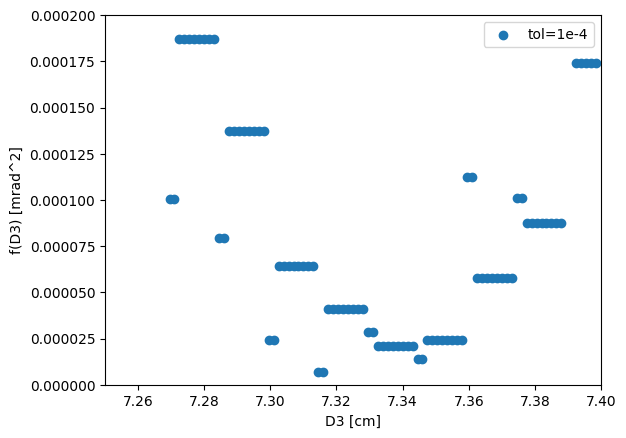

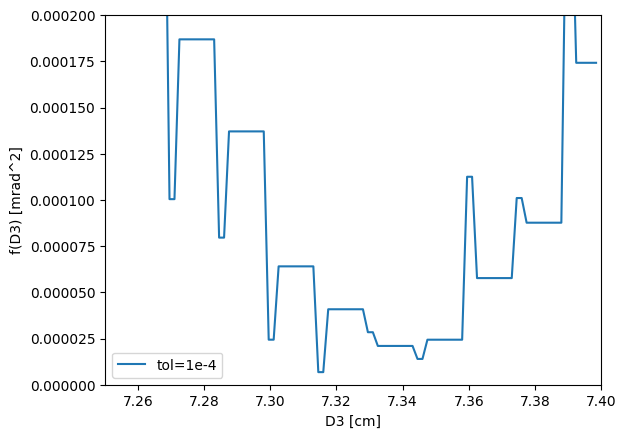

In [70]:
plt.scatter(D3vals, funcVals, label="tol=1e-4")
plt.xlabel("D3 [cm]")
plt.ylabel("f(D3) [mrad^2]")
plt.xlim(7.25,7.4)
plt.ylim(0,0.0002)

plt.legend()
plt.show()


plt.plot(D3vals, funcVals, label="tol=1e-4")
plt.xlabel("D3 [cm]")
plt.ylabel("f(D3) [mrad^2]")
plt.xlim(7.25,7.4)
plt.ylim(0,0.0002)

plt.legend()
plt.show()

## ComparisonAnaNum()
For this comparison, the fringe fields stay off. The first run is with analytical solution, the second run is with found numerical solution. The 2 results can be compared in a table below. The differences in D2,D3 are in Delta D2 and Delta D3. Parameters of runs are also there.

In [25]:
def someFunc():
    '''
    args = sys.argv
    args.pop(0)
    if len(args) != 1:
        print(f"more than 1 argument")
    tolerance = float(args[0])
    '''
    topHatShapedQuads(0)
    #boundaries for D2, D3    
    Dmin = [0.0, 0.0]
    Dmax = [0.4, 0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    tolerance=1e-2
    D1 = [0.1]
    #for i in range(1,21):
    #    D1.append(i/100)
    
    D2P1, D2P2, D2NM1, D2NM2, D2C1,D2C2 = [], [], [],[], [], []
    D3P1, D3P2, D3NM1, D3NM2, D3C1,D3C2 = [], [], [],[], [], []
    funkValP1, funkValP2, funkValNM1, funkValNM2, funkValC1, funkValC2 = [], [], [],[] ,[],[]
    timeP1, timeP2, timeNM1, timeNM2, timeC1, timeC2 = [], [], [], [], [], []
    
    for d1 in D1:    
        time1 = time.time()
        res = sc.optimize.minimize(func, (0.1, 0.1),method="Powell", bounds=bounds,tol=tolerance, args=( d1, 1, 4.5E+8 ))
        time2 = time.time()
        plotRefXY(d1, *res.x, 1, 4.5E+8)
        print(f"Time to find solution: {time2-time1} s")
        print(f"Number of iterations: {res.niter}")
        #D2P1.append(res.x[0])
        #D3P1.append(res.x[1])
        #funkValP1.append(parallelFocusing(runRef(d1, *res.x, 4.5E+8, False)))
        #timeP1.append(time2 -time1)
        
        time1 = time.time()
        bounds2 = [(res.x[0]-0.05, res.x[0]+0.05),(res.x[1]-0.05, res.x[1]+0.05)]
        res = sc.optimize.minimize(func, (random.uniform(res.x[0]-0.05, res.x[0]+0.05), random.uniform(res.x[1]-0.05, res.x[1]+0.05)),method="Powell", bounds=bounds2,tol=tolerance, args=( d1,1, 4.5E+8 ))
        time2 = time.time()
        plotRefXY(d1, *res.x, 1, 4.5E+8)
        print(f"Time to find solution: {time2-time1} s")
        #D2P2.append(res.x[0])
        #D3P2.append(res.x[1])
        #funkValP2.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
        #timeP2.append(time2 -time1)
        #------------------------------------------------------------------
        time1 = time.time()
        res = sc.optimize.minimize(func, (0.1, 0.1),method="Nelder-Mead", bounds=bounds,tol=tolerance, args=( d1,1, 4.5E+8 ))
        time2 = time.time()
        plotRefXY(d1, *res.x, 1, 4.5E+8)
        print(f"Time to find solution: {time2-time1} s")
        #D2NM1.append(res.x[0])
        #D3NM1.append(res.x[1])
        #funkValNM1.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
        #timeNM1.append(time2 -time1)
        
        time1 = time.time()
        bounds2 = [(res.x[0]-0.05, res.x[0]+0.05),(res.x[1]-0.05, res.x[1]+0.05)]
        res = sc.optimize.minimize(func, (random.uniform(res.x[0]-0.05, res.x[0]+0.05), random.uniform(res.x[1]-0.05, res.x[1]+0.05)),method="Nelder-Mead", bounds=bounds2,tol=tolerance, args=( d1,1, 4.5E+8 ))
        time2 = time.time()
        plotRefXY(d1, *res.x, 1, 4.5E+8)
        print(f"Time to find solution: {time2-time1} s")
        #D2NM2.append(res.x[0])
        #D3NM2.append(res.x[1])
        #funkValNM2.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
        #timeNM2.append(time2 -time1)
        #------------------------------------------------------------------
        
        time1 = time.time()
        res = sc.optimize.minimize(func, (0.1, 0.1),method="COBYLA", bounds=bounds,tol=tolerance, args=( d1, 4.5E+8 ))
        time2 = time.time()
        plotRefXY(d1, *res.x, 1, 4.5E+8)
        print(f"Time to find solution: {time2-time1} s")
        #D2C1.append(res.x[0])
        #D3C1.append(res.x[1])
        #funkValC1.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
        #timeC1.append(time2 -time1)
        
        time1 = time.time()
        bounds2 = [(res.x[0]-0.05, res.x[0]+0.05),(res.x[1]-0.05, res.x[1]+0.05)]
        res = sc.optimize.minimize(func, (random.uniform(res.x[0]-0.05, res.x[0]+0.05), random.uniform(res.x[1]-0.05, res.x[1]+0.05)),method="COBYLA", bounds=bounds2,tol=tolerance, args=( d1,1, 4.5E+8 ))
        time2 = time.time()
        plotRefXY(d1, *res.x, 1, 4.5E+8)
        print(f"Time to find solution: {time2-time1} s")
        #D2C2.append(res.x[0])
        #D3C2.append(res.x[1])
        #funkValC2.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
        #timeC2.append(time2 -time1)
    
    results = [D1, 
               D2P1,D3P1, funkValP1, timeP1, 
               D2P2, D3P2, funkValP2, timeP2, 
               D2NM1, D3NM1, funkValNM1, timeNM1, 
               D2NM2, D3NM2, funkValNM2, timeNM2, 
               D2C1, D3C1, funkValC1, timeC1, 
               D2C2, D3C2, funkValC2, timeC2]
    df = pd.DataFrame(results)
    df.to_csv(f"table{tolerance}.csv",index=False)


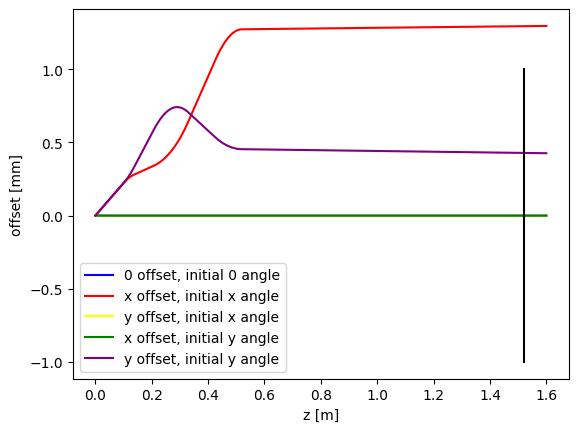

Time to find solution: 103.66707944869995 s


AttributeError: niter

In [101]:
someFunc()

In [26]:
def runPlots(file):

    df = pd.read_csv(file)
    results = df.values.tolist()
    plt.plot(results[0][:], results[3][:], label='Powell', color='blue')
    plt.plot(results[0][:], results[7][:], label='Powell w. constraints', color='red')
    plt.plot(results[0][:], results[11][:], label='Nelder-Mead', color='green')
    plt.plot(results[0][:], results[15][:], label='Nelder-Mead w. constraints', color='yellow')
    plt.plot(results[0][:], results[19][:], label='COBYLA', color='purple')
    plt.plot(results[0][:], results[23][:], label='COBYLA w. constraints', color='pink')

    plt.xlabel('D1 [mm]')
    plt.ylabel('f(D1) [mrad]')
    #plt.xlim(0.085, 0.1)
    #plt.ylim(0., 0.0)
    plt.yscale('log')
    plt.title(f"found minima for tolerance {file.replace('tables/table','').replace('.csv','')}")
    plt.legend()
    plt.show()

    

    plt.plot(results[0][:], results[4][:], label='Powell', color='blue')
    plt.plot(results[0][:], results[8][:], label='Powell w. constraints', color='red')
    plt.plot(results[0][:], results[12][:], label='Nelder-Mead', color='green')
    plt.plot(results[0][:], results[16][:], label='Nelder-Mead w. constraints', color='yellow')
    plt.plot(results[0][:], results[20][:], label='COBYLA', color='purple')
    plt.plot(results[0][:], results[24][:], label='COBYLA w. constraints', color='pink')

    plt.xlabel('D1 [mm]')
    plt.ylabel('time [s]')
    #plt.xlim(0.085, 0.1)
    #plt.ylim(0., 0.0)
    #plt.yscale('log')
    plt.title(f"found minima for tolerance {file.replace('tables/table','').replace('.csv','')}")
    plt.legend()
    plt.show()

    tables = os.listdir("tables/")
    tables = sorted(tables)
    data = {"func values [mrad]": ['Powell', "Powell w. constraints", "Nelder-Mead", "Nelder-Mead w. constraints", "COBYLA", "COBYLA w. constraints" ]}
    df = pd.DataFrame(data)
    data = {"time [s]": ['Powell', "Powell w. constraints", "Nelder-Mead", "Nelder-Mead w. constraints", "COBYLA", "COBYLA w. constraints" ]}    
    df2 = pd.DataFrame(data)
    for table in tables:
        d = pd.read_csv("tables/" + table)
        results = d.values.tolist()            
        
        df['tol = ' + table.replace("table","").replace(".csv","")] = [ mean(results[3][:]), mean(results[7][:]), mean(results[11][:]), mean(results[15][:]), mean(results[19][:]), mean(results[23][:]) ]
        df2['tol = ' + table.replace("table","").replace(".csv","")] = [ mean(results[4][:]), mean(results[8][:]), mean(results[12][:]), mean(results[16][:]), mean(results[20][:]), mean(results[24][:]) ]
        
    return df, df2

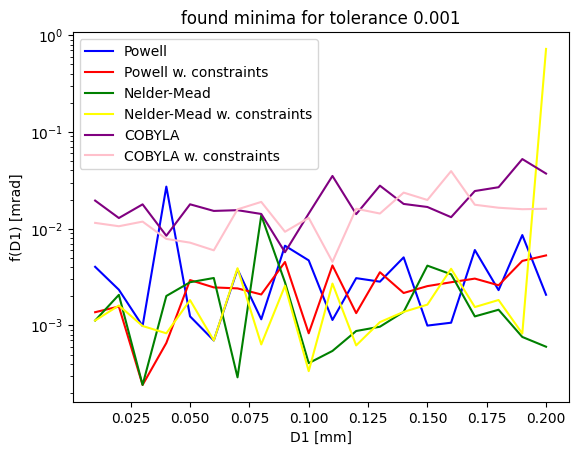

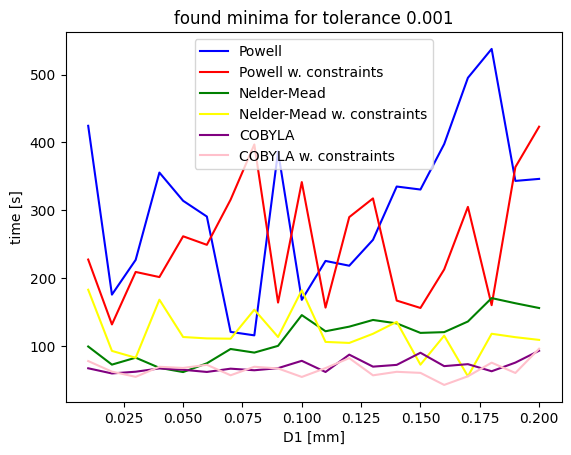

func values [mrad]  tol = 0.0000000001  tol = 0.000000001  \
0                      Powell            0.003302           0.003193   
1       Powell w. constraints            0.001980           0.002115   
2                 Nelder-Mead            0.001363           0.001363   
3  Nelder-Mead w. constraints            0.016320           0.038812   
4                      COBYLA            0.006476           0.006476   
5       COBYLA w. constraints            0.004322           0.003626   

   tol = 0.00000001  tol = 0.0000001  tol = 0.000001  tol = 0.00001  \
0          0.003111         0.003588        0.004636       0.002721   
1          0.001412         0.001934        0.001800       0.002214   
2          0.001363         0.001363        0.001363       0.001363   
3          0.001038         0.001244        0.037456       0.015987   
4          0.006476         0.006476        0.006476       0.006848   
5          0.002741         0.004638        0.005291       0.006344   

   tol = 0.0001  tol = 0.001  tol = 0.01  tol = 0.1  
0      0.002256     0.004301    0.008881   0.111835  
1      0.001743     0.002563    0.004324   0.232918  
2      0.001363     0.002195    0.020657   0.511330  
3      0.000686     0.037534    0.032788   0.536492  
4      0.008921     0.020368    0.161871   0.775781  
5      0.007304     0.014783    0.120588   0.741339

In [148]:
df, df2 = runPlots("tables/table0.001.csv")
#function values
df

In [147]:
#timing
df2

time [s]  tol = 0.0000000001  tol = 0.000000001  \
0                      Powell          886.092137         840.719961   
1       Powell w. constraints          796.400991         823.733697   
2                 Nelder-Mead          325.732110         294.017659   
3  Nelder-Mead w. constraints          326.879819         293.239645   
4                      COBYLA          128.321549         122.418044   
5       COBYLA w. constraints          119.963410         112.409950   

   tol = 0.00000001  tol = 0.0000001  tol = 0.000001  tol = 0.00001  \
0        768.238415       651.265082      562.840437     453.128190   
1        627.134929       534.216818      517.443568     414.260731   
2        262.088254       230.802726      198.992387     166.099056   
3        266.038435       237.555027      201.998619     169.528980   
4        117.867609       113.785627      108.880376     103.442603   
5        109.779421       106.451186      101.145696      94.244308   

   tol = 0.0001  tol = 0.001  tol = 0.01  tol = 0.1  
0    387.510954   303.052142  212.666196  69.482387  
1    292.200812   252.328934  192.615885  22.853297  
2    137.696698   113.595764   64.121605   7.746534  
3    140.485885   117.634667   75.011442  12.657994  
4     92.478482    70.428169   44.293061  20.885113  
5     84.117480    65.191933   38.017154  15.096742

In [27]:
def study(inputFile):

    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.4,0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    
    '''
    results = D1, D2, D3, momZ,f_MAXIMA, f_topHat_found, f_fringeFields, f_fringeFields_found, f_fieldProfile, f_fieldProfile_found
    '''
    with open(inputFile, "r") as file:
        setups = file.readlines()

    
    setup = []
    for line in setups:
        line = line.replace("\n","")
        line = line.split(" ")  
        setup.append(line)
    #setup = [[0.1, 0.056362, 0.101014 ,4.5E+8]]

    results = []
    #sigInAccept = ""
    #sigOutAccept = ""

    for line in setup:
        current_res = []
        current_res.extend(line)
        topHatShapedQuads(0)
        current_res.append(angleCalculation(runRef(float(line[0]), float(line[1]), float(line[2]), float(line[3]), False)))
        plotRefXY1(float(line[0]), float(line[1]), float(line[2]), float(line[3]), f"MAXIMA solution for top hat field, setup: {line}, f={current_res[-1]} mrad")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Nelder-Mead", bounds=bounds,tol=1e-3, args=(float(line[0]), float(line[3])))
        current_res.append(angleCalculation(runRef(float(line[0]),*res.x , float(line[3]), False)))
        plotRefXY1(float(line[0]), *res.x, float(line[3]), f"Numerical solution for top hat field, setup: {res.x} with f={current_res[-1]} mrad")

        topHatShapedQuads(1)
        current_res.append(angleCalculation(runRef(float(line[0]), float(line[1]), float(line[2]), float(line[3]), False)))
        plotRefXY1(float(line[0]), float(line[1]), float(line[2]), float(line[3]), f"MAXIMA solution Astra fringe fields, setup: {line}, f={current_res[-1]} mrad")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Nelder-Mead", bounds=bounds,tol=1e-3, args=(float(line[0]), float(line[3] )))
        current_res.append(angleCalculation(runRef(float(line[0]),*res.x , float(line[3]), False)))
        plotRefXY1(float(line[0]), *res.x, float(line[3]), f"Numerical solution for Astra fringe fields, setup: {res.x} with f={current_res[-1]} mrad")

        topHatShapedQuads(2)
        current_res.append(angleCalculation(runRef(float(line[0]), float(line[1]), float(line[2]), float(line[3]), False)))
        plotRefXY1(float(line[0]), float(line[1]), float(line[2]), float(line[3]), f"MAXIMA solution field profile, setup: {line}, f={current_res[-1]} mrad")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Nelder-Mead", bounds=bounds,tol=1e-3, args=(float(line[0]), float(line[3] )))
        current_res.append(angleCalculation(runRef(float(line[0]),*res.x , float(line[3]), False)))
        plotRefXY1(float(line[0]), *res.x, float(line[3]), f"Numerical solution for field profile, setup: {res.x} with f={current_res[-1]} mrad")

        #current_res.extend(checkAngleAcceptance()[0:2])
        results.append(current_res)


    df = pd.DataFrame(results)
    df.to_csv("table.csv",index=False)

    #with open("results.txt" , "w") as file:
    #    file.write(sigInAccept)
    #with open("errors.txt" , "w") as file:
    #   file.write(sigOutAccept)
    

    return df

In [44]:
'''
args = sys.argv
args.pop(0)
if len(args) != 1:
    print(f"more than 1 argument")
file = args[0]
'''
#file = "../../MAXIMA/analyticalResultsP.txt"
#study(file)



'\nargs = sys.argv\nargs.pop(0)\nif len(args) != 1:\n    print(f"more than 1 argument")\nfile = args[0]\n'

In [40]:
def comparisonAnaNum(setupFileName, minimalFunVal):

    update()
    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.3,0.3]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    
    with open("../../MAXIMA/" + setupFileName, "r") as file:
        stringdata = file.readlines()
        
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    '''
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", 
              "F_ana [mrad]", "F_num [mrad]", 
              "Delta D2 [mm]" , "Delta D3 [mm]",
              "setup length [m]", 
              "Angle accept. x [mrad]", "Angle accept. y [mrad]",
              "beam size x [mm]", "beam size y [mm]","beam ratio [-]",
              "active particles for sig_xyAngle = 1 mrad [%],
              "number of func. evaluations [-]",
              "x angle [mrad], y angle [mrad]",
             ]
    }
    '''
    finalTable = []
    
    resultSetups = ""
    errorSetups = ""
    initialAng = []
    
    for row in analyticData:
        #first run the analytical solution and show plots
        topHatShapedQuads(True)
        changeMom(sig_xAngle, sig_yAngle, float(row[3]), -1, -1)
        
        sumAna = angleCalculation(runRef(float(row[0]),float(row[1]), float(row[2]), float(row[3]), False))
        plotRefXY1(float(row[0]),float(row[1]), float(row[2]), float(row[3]), f"Analytic results, '{row}', top hat fields")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-6, args=(float(row[0]), float(row[3])))
        #res = sc.optimize.minimize(func, (0.15, 0.15), method="Powell", bounds=bounds, options={'ftol': 1e-8}, args=(float(row[0]), float(row[3])))
        #res = sc.optimize.minimize(func, (0.15, 0.15), method="Powell", bounds=bounds, options={'xtol': 1e-8}, args=(float(row[0]), float(row[3])))

        if not res.success or res.fun > minimalFunVal:
            print(f"Could not find numerical solution for d1 = {row[0]} and pz = {row[3]}. Skipping.")
            errorSetups += row[0] + " " + row[1] + " " + row[2] + " " + row[3] + "\n"
            continue
        
        sumNum = angleCalculation(runRef(float(row[0]),*res.x , float(row[3]), False))
        plotRefXY1(float(row[0]),*res.x, float(row[3]), f"Numerical results, ['{row[0]}', '{res.x[0]}', '{res.x[1]}', '{row[3]}'], top hat fields")
        resultSetups += row[0] + " " + str(res.x[0]) + " " + str(res.x[1]) + " " + row[3] + "\n"
        row.append(sumAna)
        row.append(sumNum)
        
        DeltaD2 = math.fabs(float(row[1]) - res.x[0])*1000 
        DeltaD3 = math.fabs(float(row[2]) - res.x[1])*1000
        row.append( DeltaD2 )
        row.append( DeltaD3 )
        
        row.append( setupSize(float(row[0]), *res.x ))
        angleAcceptance = checkAngleAcceptance(float(row[0]), *res.x, float(row[3]))
        row.append(angleAcceptance[0])
        row.append(angleAcceptance[1])
        row.append(angleAcceptance[2])
        row.append(angleAcceptance[3])
        row.append(angleAcceptance[2]/angleAcceptance[3])
        row.append(angleAcceptance[4])
        row.append(res.nfev)
        finalTable.append(row)
        

    print(resultSetups)
    print(errorSetups)
    if resultSetups != "":
        with open("results.txt", "w") as file:
            file.write(resultSetups)
    if errorSetups != "":
        with open("errors.txt","w") as file:
            file.write(errorSetups)

    
    return finalTable

In [41]:
def plotResultsAcceptance(file, file2):

    df = pd.read_csv(file)
    list = df.values.tolist()

    data = []
    for i in range(160):
        data.append(list[i*18])

    
    for i in range(10):
        D1 = [value[0] for value in data[i*16:(i+1)*16]]        
        Pz = [value[3]*1e-6 for value in data[i*16:(i+1)*16]]
        acceptX = [value[4] for value in data[i*16:(i+1)*16]]
        acceptY = [value[5] for value in data[i*16:(i+1)*16]]

        plt.scatter(Pz, acceptX, color='blue', label='acceptance X')
        plt.scatter(Pz, acceptY, color='red', label='acceptance Y')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("acceptance [mrad]")
        plt.title(f"Plot of acceptances w.r.t. momentum for D1 = {i +1} cm")
        plt.show()

    
    df = pd.read_csv(file2)
    list = df.values.tolist()

    data = []
    for i in range(160):
        data.append(list[i*18])

    for i in range(16):
        D1 = [value[0]*1e+2 for value in data[i*10:(i+1)*10]]
        Pz = [value[3]*1e-6 for value in data[i*10:(i+1)*10]]
        acceptX = [value[4] for value in data[i*10:(i+1)*10]]
        acceptY = [value[5] for value in data[i*10:(i+1)*10]]

        plt.scatter(D1, acceptX, color='blue', label='acceptance X')
        plt.scatter(D1, acceptY, color='red', label='acceptance Y')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("acceptance [mrad]")
        plt.title(f"Plot of acceptances w.r.t. D1 for Pz = {250 + i*50} MeV")
        plt.show()

    



In [42]:
def plotResultsSigmaSpread(file):


    df = pd.read_csv(file)
    data = df.values.tolist()

    #results = D1, D2, D3, momZ, xAccept, yAccept,xAng_sig, yAng_sig, beam size X, beam size Y, percentagePassed,


    for i in range(1):
        #D1 = [value[0] for value in data[i*18:(i+1)*18]]        
        #Pz = [value[3]*1e-6 for value in data[i*18:(i+1)*18]]
        #acceptance
        angleSig = [value[6] for value in data]
        beamX = [value[8] for value in data]
        beamY = [value[9] for value in data]
        perPassed = [value[10] for value in data]

        plt.scatter(angleSig, perPassed, color='blue', label='percentage of passed particles')
        #plt.legend()
        plt.xlabel("initial sigma spread [mrad]")
        plt.ylabel("particles passed [%]")
        plt.title(f"Plot of particles passed w.r.t. initial sigma angle spread for setup with acceptance {data[0][4]}, {data[0][5]}")
        plt.show()  
        
        plt.scatter(angleSig, beamX, color='blue', label='beam size X')
        plt.scatter(angleSig, beamY, color='red', label='beam size Y')
        plt.legend()
        plt.xlabel("initial sigma spread [mrad]")
        plt.ylabel("beam size [mm]")
        plt.title(f"Plot of beam sizes w.r.t. to initial angle spread  for setup with acceptance {data[0][4]}, {data[0][5]}")
        plt.show()
        


        


In [43]:
def plotResultsD1(data):

    for i in range(10): 
        D1 = [row[0]*100 for row in data[i*16: i*16 + 15]]
    
        Pz = [value[3]*1e-6 for value in data[i*16:i*16 + 15]]
        deltaD2 = [value[6] for value in data[i*16:i*16 + 15]]
        deltaD3 = [value[7] for value in data[i*16:i*16 + 15]]
        funkAna = [value[4] for value in data[i*16: i*16 + 15]]
        funkNum = [value[5] for value in data[i*16: i*16 + 15]]
        setupLength = [value[8] for value in data[i*16:i*16 + 15]]
        xAcceptance = [value[9] for value in data[i*16:i*16 + 15]]
        yAcceptance = [value[11] for value in data[i*16:i*16 + 15]]

        #deltas w.r.t. D1, Pz
        plt.scatter(Pz, deltaD2, color='blue', label='Delta D2')
        plt.scatter(Pz, deltaD3, color='red', label='Delta D3')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("delta [mm]")
        plt.title(f"Plot of differences between MAXIMA results and ASTRA minimization for D1 = {1*i +1} cm")
        plt.show()
    
        plt.scatter(Pz,funkAna , color='blue', label='MAXIMA solution')
        plt.scatter(Pz, funkNum, color='red', label='ASTRA minimization')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("f(D2,D3) [mrad]")
        plt.title(f"Plot of function results between MAXIMA and ASTRA minimization for D1 = {1*i +1} cm")
        plt.show()

        
        #setup length w.r.t. D1, Pz
        plt.scatter(Pz, setupLength, color='blue', label='length of setup [m]')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("length [m]")
        plt.title(f"Length of setup with ASTRA minimized solution for D1 = {i + 1} cm")
        plt.show()
        
    
        plt.scatter(Pz, xAcceptance, color='blue', label='Acceptance x ')
        plt.scatter(Pz, yAcceptance, color='red', label='Acceptance y')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("initial angle [mrad]")
        plt.title(f"Plot of acceptance with ASTRA minimized solution for D1 = {i + 1} cm")
        plt.show()
    



    return

In [44]:
def plotResultsPz(data):

    for i in range(16): 
        D1 = [row[0]*100 for row in data[i*10: i*10 + 9]]

        Pz = [value[3]*1e-6 for value in data[i*10: i*10 + 9]]
        deltaD2 = [value[6] for value in data[i*10: i*10 + 9]]
        deltaD3 = [value[7] for value in data[i*10: i*10 + 9]]
        funkAna = [value[4] for value in data[i*10: i*10 + 9]]
        funkNum = [value[5] for value in data[i*10: i*10 + 9]]
        setupLength = [value[8] for value in data[i*10: i*10 + 9]]
        xAcceptance = [value[9] for value in data[i*10: i*10 + 9]]
        yAcceptance = [value[11] for value in data[i*10: i*10 + 9]]
        '''
        #deltas w.r.t. D1, Pz
        plt.scatter(D1, deltaD2, color='blue', label='Delta D2')
        plt.scatter(D1, deltaD3, color='red', label='Delta D3')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("delta [mm]")
        plt.title(f"Plot of differences between MAXIMA results and ASTRA minimization for Pz = {250 + i*50} MeV")
        plt.show()
    
        plt.scatter(D1,funkAna , color='blue', label='MAXIMA solution')
        plt.scatter(D1, funkNum, color='red', label='ASTRA minimization')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("f(D2,D3) [mrad]")
        plt.title(f"Plot of function results between MAXIMA and ASTRA minimization for Pz = {250 + i*50} MeV")
        plt.show()

        
        #setup length w.r.t. D1, Pz
        plt.scatter(D1, setupLength, color='blue', label='length of setup [m]')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("length [m]")
        plt.title(f"Length of setup with ASTRA minimized solution for Pz = {250 + i*50} MeV")
        plt.show()
        '''
    
        plt.scatter(D1, xAcceptance, color='blue', label='Acceptance x ')
        plt.scatter(D1, yAcceptance, color='red', label='Acceptance y')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("initial angle [mrad]")
        #plt.yscale('log')
        plt.title(f"Plot of acceptance with ASTRA minimized solution for Pz = {250 + 50*i} MeV")
        plt.show()
    



    return

In [77]:
'''
args = sys.argv
args.pop(0)
if len(args) != 1:
    print(f"more than 1 argument")

dataFileName = str(args[0])
matrix = comparisonAnaNum(dataFileName, 1)
df = pd.DataFrame(matrix)
df.to_csv('table.csv', index=False)


matrix = comparisonAnaNum("analyticalResultsP_1.txt", 100)
df = pd.DataFrame(matrix)
df.to_csv('table.csv', index=False)
matrix = [[1,2,3,4],[5,6,7,8]]
df = pd.DataFrame(matrix)
df.to_csv('table.csv', index=False)
df = pd.read_csv('../runParallel/Run2/tablePz.csv')
#df = pd.read_csv('../runParallel/Run2/tableD1.csv')
list_of_lists = df.values.tolist()

plotResultsPz(list_of_lists)
'''


'\nargs = sys.argv\nargs.pop(0)\nif len(args) != 1:\n    print(f"more than 1 argument")\n\ndataFileName = str(args[0])\nmatrix = comparisonAnaNum(dataFileName, 1)\ndf = pd.DataFrame(matrix)\ndf.to_csv(\'table.csv\', index=False)\n\n\nmatrix = comparisonAnaNum("analyticalResultsP_1.txt", 100)\ndf = pd.DataFrame(matrix)\ndf.to_csv(\'table.csv\', index=False)\nmatrix = [[1,2,3,4],[5,6,7,8]]\ndf = pd.DataFrame(matrix)\ndf.to_csv(\'table.csv\', index=False)\ndf = pd.read_csv(\'../runParallel/Run2/tablePz.csv\')\n#df = pd.read_csv(\'../runParallel/Run2/tableD1.csv\')\nlist_of_lists = df.values.tolist()\n\nplotResultsPz(list_of_lists)\n'

In [78]:
def getResults(setupFileName):
    #this a function which compares analytical solution with numerical solution and with regards to fringe fields

    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.4,0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    
    D1 = []
    Pz = []
    for i in range(1,4):
        D1.append(0.1*i)
        Pz.append(2E+8 + i*2E+7)

    
    results = ""
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_num [keV]","D [m]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1

    for d1 in D1:
        print(f"Running {d1}")
        for pz in Pz:
            print(f"Running {pz}")            
            topHatShapedQuads(True)
            res = sc.optimize.minimize(func, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(d1, pz))
            sum = angleCalculation(runRef(d1,*res.x , pz, False))
            results += str(d1) + " " + str(res.x[0]) + " " + str(res.x[1]) + " " + str(pz) + "\n"
            fill4DGraph(d1, res.x[0], res.x[1], pz, sum)
            df['setup ' + str(i)] = [d1, res.x[0], res.x[1], pz, sum, d1+res.x[0] +res.x[1] ]
        
        i += 1
        
    with open(setupFileName,"w") as file:
        file.write(results)

    
    return df
    

In [79]:
#df = getResults("results.txt")
#df.to_csv('resFigs/table.csv', index=False)


## Functions to study sensitivity
The following functions are implemented with a goal to study how sensitive or stable a solution is when some parameters or variables are being alternated. runAna() studies variability in D1, D2, D3, Pz and initial Px, Py. The input of the function is a solution- a functioning setup. For each variable function prints a graph with logarithmic x axis representing change in the variable, the logarithmic y axis returns relative change in the function (angleCalculation() ). 
Below that is another function which studies the initial x and y offset. 

In [28]:
#analytic: 0.10 0.1767908617405159 0.1859304244423013 700000000
def runAna(D1,D2, D3, momZ, switch):  
    topHatShapedQuads(True)
    update()
    input = [D1, D2, D3, momZ]
    #--------------------------------------------------------------------------------------------------------------------------
    print(f"Varying D1 in range from 1 cm to 10 mikrometers")
    difs = [0.01, 0.005,0.003, 0.002, 0.001, 0.0005,0.0003, 0.0002, 0.0001,0.00005 ,0.00003, 0.00002, 0.00001]
    graphDataMX = []
    graphDataMY = []
    graphDataPX = []
    graphDataPY = []
    if switch == 1:
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1+dif,D2,D3, momZ, False)
            dataTestM = runRef(D1-dif,D2, D3, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D1 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D1 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D1 with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 2:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying D2 in range from 1 cm to 10 mikrometers")
        
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2+dif,D3, momZ, False)
            dataTestM = runRef(D1,D2-dif, D3, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D2 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D2 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D2 with input '{input}'")
        plt.legend()
        plt.show()


    elif switch == 3:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying D3 in range from 1 cm to 10 mikrometers")
        
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2,D3+dif, momZ, False)
            dataTestM = runRef(D1,D2, D3-dif, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D3 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D3 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D3 with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 4:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying Pz in range from 50 MeV to 1 eV")
        difMoms = [5e+7, 3e+7 , 1e+7, 5e+6, 3e+6, 1e+6, 5e+5, 3e+5, 1e+5, 5e+4, 3e+4, 1e+4, 5e+3, 3e+3, 1e+3, 5e+2 , 3e+2, 1e+2, 50, 30 ,10, 5, 3, 1] #from 50 MeV to 1 keV
        
        for dif in difMoms:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2,D3, momZ+dif, False)
            dataTestM = runRef(D1,D2, D3, momZ-dif, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='Pz + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='Pz - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [eV]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying Pz with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 5:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying initial angle in x and y direction in range from 10 mrad to 0.01 mrad")
        difAngle = [1e-1, 5e-2, 3e-2,1e-2, 5e-3, 3e-3, 1e-3, 5e-4, 3e-4, 1e-4, 5e-5, 3e-5, 1e-5] 
        
        for dif in difAngle:
            print(f"Running '{dif*1000}' mrad")
            changeMom(xmom,ymom,momZ,-1, -1)
            dataControl = runRef(D1,D2,D3,momZ, False)
            changeMom(dif*momZ, dif*momZ, momZ, -1, -1)
            dataTestP = runRef(D1,D2,D3, momZ, False)
    
            if dataControl == 1:
                print("Something is wrong with control data")
                return
            
            if dataTestP == 1:
                relChangeP = 1000
            else:
                relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
                plotRefXY1(D1,D2,D3,momZ,f"dif '{dif*1000}' mrad")
    
            
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='Vary Px')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [rad]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying Px and Py with input '{input}'")
        plt.legend()
        plt.show()

    return

In [29]:
def runAnaOffset(D1,D2, D3, momZ):
    #this function varies initial offset 
    
    topHatShapedQuads(True)
    update()
    
    input = [D1, D2, D3, momZ]

    difs = [0.005,0.003, 0.001, 0.0005,0.0003, 0.0001,0.00005 ,0.00003, 0.00001, 5.0E-6, 3.0E-6, 1.0E-6,5.0E-7, 3.0E-7, 1.0E-7, 5.0E-8, 3.0E-8, 1.0E-8,5.0E-9, 3.0E-9, 1.0E-9 ]
    #difs = [5.0E-7, 3.0E-7, 1.0E-7, 1E-8, 1E-9, 1E-10 ]

    graphDataMX = []
    graphDataMY = []
    graphDataPX = []
    graphDataPY = []
    
    #--------------------------------------------------------------------------------------------------------------------------
    print(f"Varying initial offset in x and y direction in range from 10 mrad to 0.01 mrad")
    
    for dif in difs:
        print(f"Running '{dif*1000}' mm")
        changeMom(1E+4,1E+4,momZ,0, 0)
        dataControl = runRef(D1,D2,D3,momZ, False)
        changeMom(xmom,ymom, momZ, dif, dif)
        dataTestP = runRef(D1,D2,D3, momZ, False)

        if dataControl == 1:
            print("Something is wrong with control data")
            return
        
        if dataTestP == 1:
            relChangeP = 1000
            relChangeM = 1000
        else:
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculationInverse(dataTestP))*100/angleCalculation(dataControl)
            plotRefXY2(D1,D2,D3,momZ,f"offset '{dif*1000}' mm")

        
        graphDataPX.append(dif*1e+3)
        graphDataPY.append(relChangeP)        
        graphDataMX.append(dif*1e+3)
        graphDataMY.append(relChangeM)   
    
    plt.scatter(graphDataPX, graphDataPY, color='blue', label='x offset in px != 0...')
    plt.scatter(graphDataMX, graphDataMY, color='red', label='y offset in px != 0...')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')
    plt.xlabel('change [mm]')
    plt.ylabel('rel. change in angle sum [%]')
    plt.title(f"varying Px and Py with input '{input}'")
    plt.legend()
    plt.show()



In [82]:
#study of sensitivity w.r.t. varying to D1, D2, D3
#runAna(0.10, 0.176790, 0.185930, 7e+8)
#runAnaOffset(0.10, 0.176790, 0.185930, 7e+8)

In [85]:
def findInfo(D1,D2,D3,D4, momZ):

    currentData = runRef(D1,D2,D3,D4,momZ,True)

    result = []
    result.append( setupSize(D1,D2,D3,D4) )
    accept = checkAngleAcceptance(D1,D2,D3,D4, momZ)
    if accept == 1:
        print(f"Cannot check angle acceptance for {D1, D2, D3, D4,momZ}.")
        return 1
    result.append(accept[0])
    result.append(accept[1])

    positions = changePositions(D1,D2,D3,D4)

    data = []
    data.append(list(currentData[1][0]))
    data.append(list(currentData[2][0]))
    closest = 0.1
    bestLine = []
    #look for closest in the x direction
    for j in range(len(currentData[1])):
        dist = math.fabs(currentData[1][j][0] - positions[3])
        if dist < closest:
            bestLine = list(currentData[1][j])
            closest = float(dist)
    data.append(list(bestLine))

    
    #look for closest in the y direction
    closest= 0.1
    for j in range(len(currentData[2])):
        dist = math.fabs(currentData[2][j][0] - positions[3])
        if dist < closest:
            bestLine = list(currentData[2][j])
            closest = float(dist)
    data.append(list(bestLine))

    
    #data: 0=z, 1=t, 2=Pz [MeV],5-x [mm], 6=y [mm], 7=px [eV], 8=py [eV] 

    #x_2/x'_1
    num = data[2][5]/ (data[0][7]*1e-3/data[0][2])
    result.append(num)
    #y_2/y'_1
    num = data[3][6]/ (data[1][8]*1e-3/data[1][2])
    result.append(num)

    #x_2/x_1
    num = data[2][5]/data[0][5]
    result.append(num)
    num = data[3][6]/data[1][6]
    result.append(num)

    #x'_2/x'_1
    num =  (data[2][7]*1e-3/data[2][2])/ (data[0][7]*1e-3/data[0][2])
    result.append(num)
    num =  (data[3][8]*1e-3/data[3][2])/ (data[1][8]*1e-3/data[1][2])
    result.append(num)

    return result
    

In [81]:
def function(D, D1,D4, momZ, switch):

    #print(f"input D2, D3 = {D}")
    
    dataCurrent = runRef(D1, D[0], D[1], D4, momZ, False)
    if dataCurrent == 1:
        return 1E+9
    
    if switch == "parallel":    
        sum = parallelFocusing(dataCurrent)
    elif switch == "point":
        sum = pointFocusing(dataCurrent)
    elif switch == "lineX":
        sum = xLineFocusing(dataCurrent)
    elif switch == "lineY":
        sum = yLineFocusing(dataCurrent)

    #print(D, sum)
        
    return sum

In [31]:
def runAstra(inputFile):
    #complex function to run analysis of a setup
    
    Dmin = [0.0,0.0]
    Dmax = [1.0,1.0]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    method = "Powell"
    tolerance = 1e-6
    fields = ["top hat fields", "Astra fringe fields", "field profiles"]
    
    with open(inputFile, "r") as file:
        input = file.readlines()


    setups = []
    for i,line in enumerate(input):
        line = line.replace("\n","")
        line = line.split(" ")  
        num = [float(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])]
        setups.append(num)

    results = [[], [], []]
    #print(setups)
    for i in range(3): 
        topHatShapedQuads(i)
        for setup in setups:
            #parallel
            time1 = time.time()
            res1 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0],setup[3],  setup[4], "parallel") )
            time2 = time.time()
            if not res1.success:
                print(f"Did not obtain result for parallel focusing. The result turned out {res1.x}")
                continue 
            plotRefXY2(setup[0], *res1.x, setup[3],setup[4], f"Found solution for {fields[i]}, parallel focusing,\nPz= {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s:\nD2 = {math.ceil(res1.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res1.x[1]*1e+5)/1000} cm", f"parallel_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, 0 ,res1.x[0]*1e+2, res1.x[1]*1e+2] + findInfo(setup[0], *res1.x, setup[3], setup[4]))
            
            #point
            time1 = time.time()
            res2 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0], setup[3], setup[4], "point"))
            time2 = time.time()
            if not res2.success:
                print(f"Did not obtain result for point focusing. The result turned out {res2.x}")
                continue
            plotRefXY3(setup[0], *res2.x, setup[3],setup[4], f"Found solution for {fields[i]}, point-point focusing,\nPz = {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s: D2 = {math.ceil(res2.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res2.x[1]*1e+5)/1000} cm", f"pointpoint_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, setup[3]*1e+2 ,res2.x[0]*1e+2, res2.x[1]*1e+2] + findInfo(setup[0], *res2.x, setup[3], setup[4]))
            
            #x line
            time1 = time.time()
            res3 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0], setup[3], setup[4], "lineX"))
            time2 = time.time()
            if not res3.success:
                print(f"Did not obtain result for line X focusing. The result turned out {res3.x}")
                continue
            plotRefXY3(setup[0], *res3.x, setup[3],setup[4], f"Found solution for {fields[i]}, line X focusing,\nPz = {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s:\nD2 = {math.ceil(res3.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res3.x[1]*1e+5)/1000} cm", f"lineX_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, setup[3]*1e+2 ,res3.x[0]*1e+2, res3.x[1]*1e+2] + findInfo(setup[0], *res3.x, setup[3], setup[4]))

            #y line
            time1 = time.time()
            res4 = sc.optimize.minimize(function, (0.1,0.1), method=method, tol=tolerance, bounds=bounds,args=(setup[0], setup[3], setup[4], "lineY"))
            time2 = time.time()
            if not res4.success:
                print(f"Did not obtain result for line Y focusing. The result turned out {res4.x}")
                continue
            plotRefXY3(setup[0], *res4.x, setup[3],setup[4], f"Found solution for {fields[i]}, line Y focusing,\nPz = {setup[4]*1e-6} MeV, time= {math.ceil(10*(time2-time1))/10} s: D2 = {math.ceil(res4.x[0]*1e+5)/1000} cm, D3 = {math.ceil(res4.x[1]*1e+5)/1000} cm", f"lineY_Pz={setup[4]*1e-6}")
            results[i].append([setup[4]*1e-6, setup[0]*1e+2, setup[3]*1e+2 ,res4.x[0]*1e+2, res4.x[1]*1e+2] + findInfo(setup[0], *res4.x, setup[3], setup[4]))
            print(f"Timing with fields {fields[i]}: the entire process for setup: {setup} took {time2 - time1} s")
        
    df = pd.DataFrame(results[0])
    df.to_csv("topHatFields0.csv", index=False)
    
    df = pd.DataFrame(results[1])
    df.to_csv("AstraFringeFields0.csv", index=False)

    df = pd.DataFrame(results[2])
    df.to_csv("fieldProfiles0.csv", index=False)
    
    

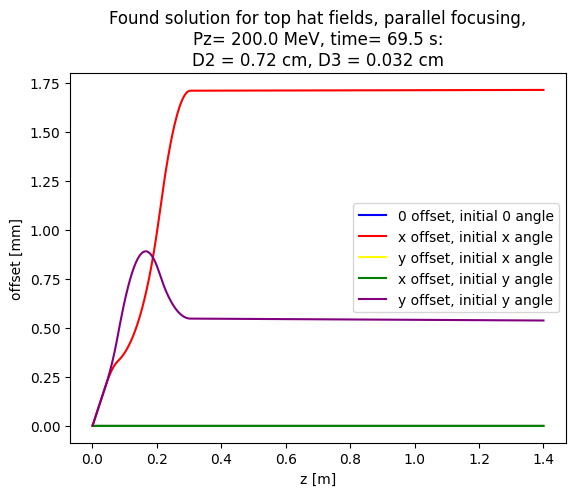

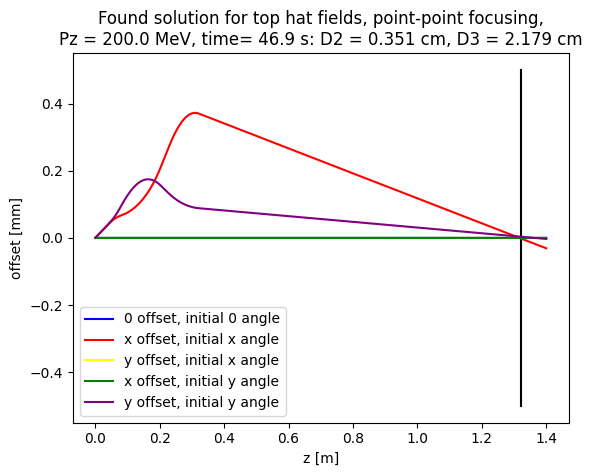

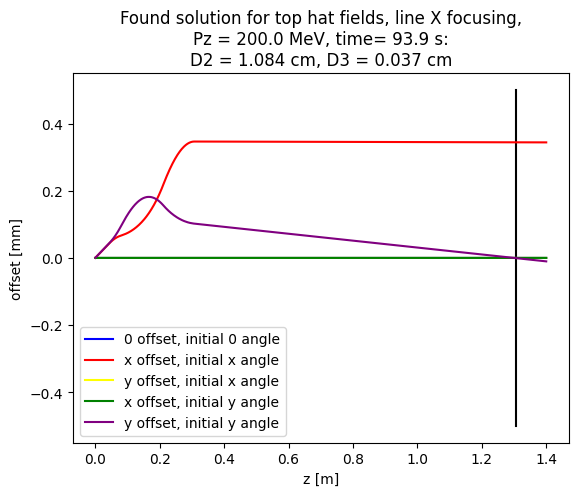

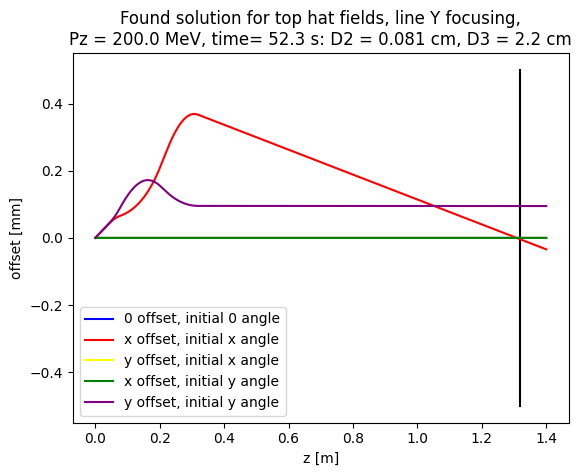

Timing with fields top hat fields: the entire process for setup: [0.04, 0.00716, 0.000302, 1.0, 200000000.0] took 52.22259211540222 s


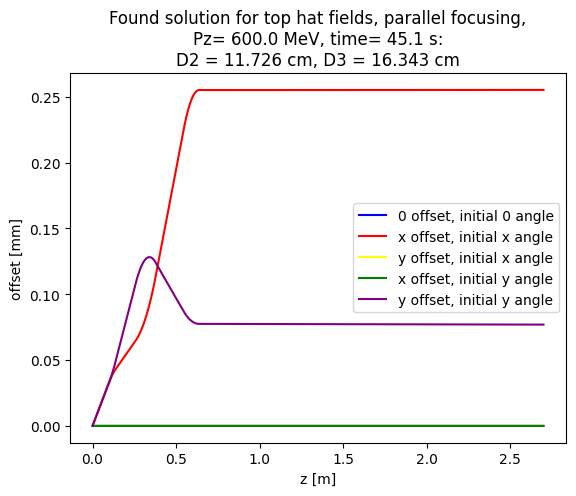

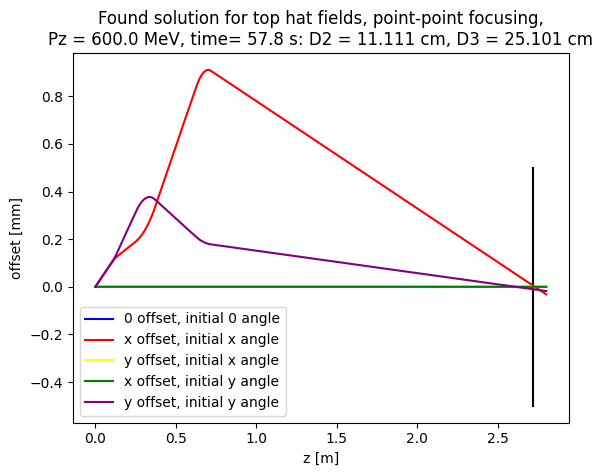

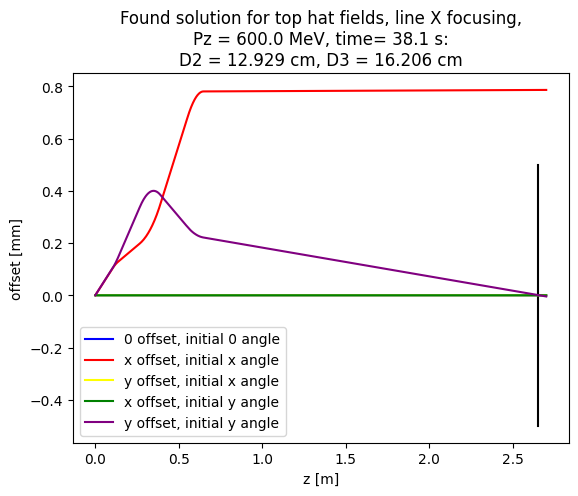

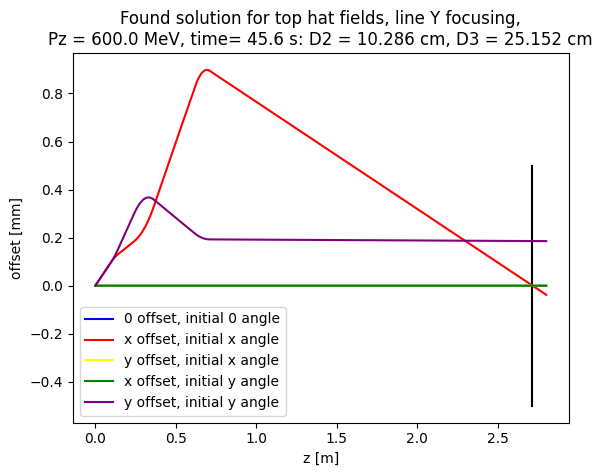

Timing with fields top hat fields: the entire process for setup: [0.1, 0.1173, 0.163348, 2.0, 600000000.0] took 45.52362895011902 s


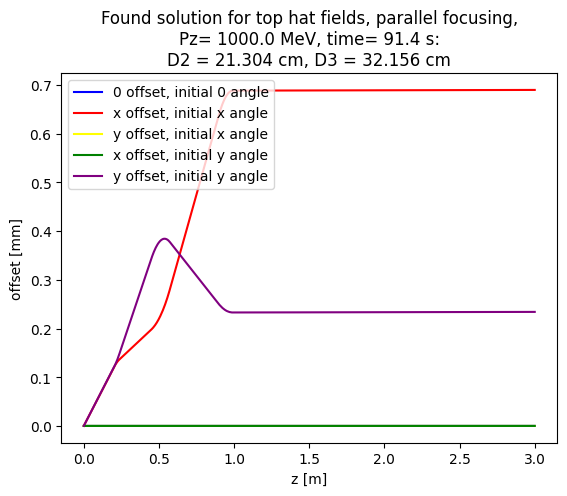

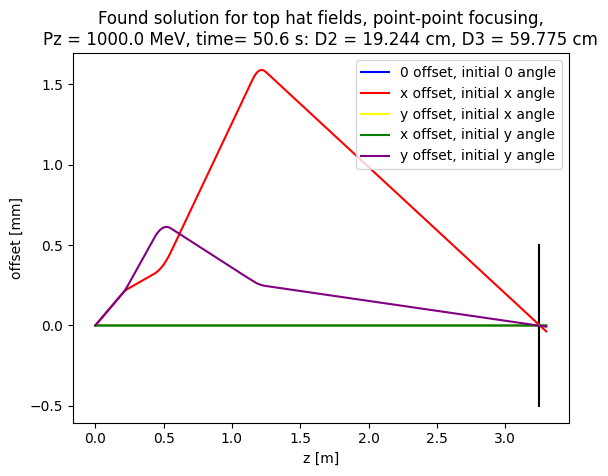

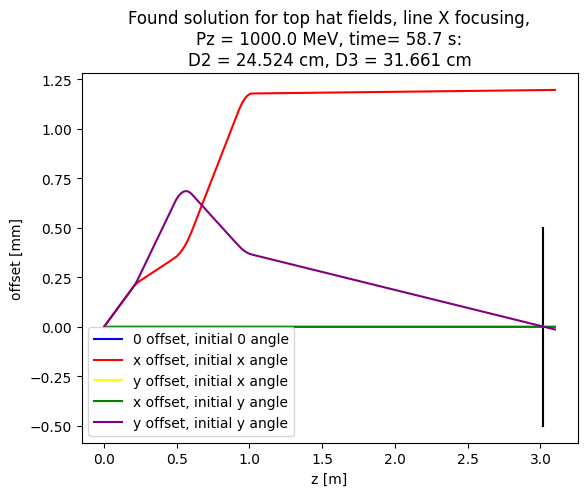

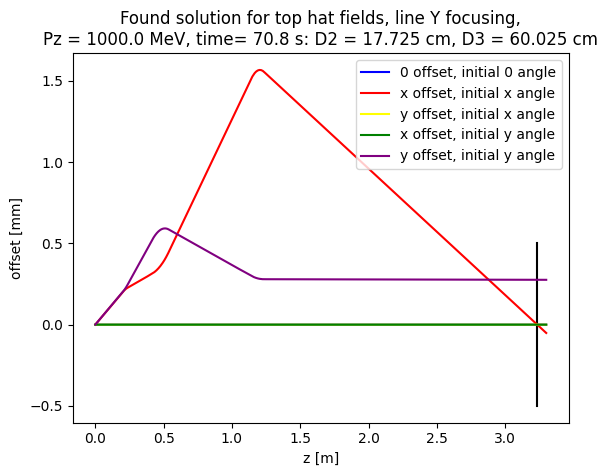

Timing with fields top hat fields: the entire process for setup: [0.2, 0.213766, 0.321644, 2.0, 1000000000.0] took 70.76719617843628 s


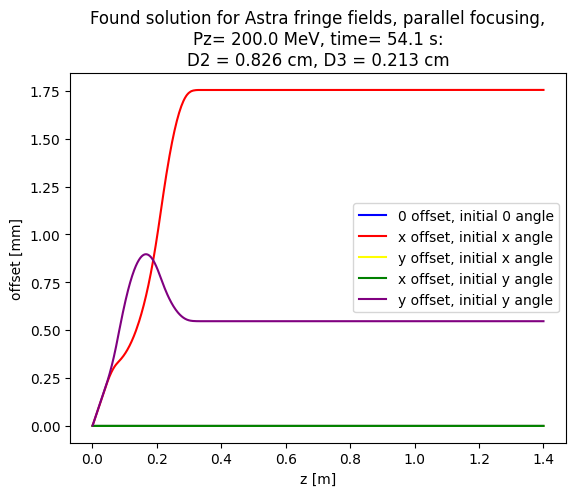

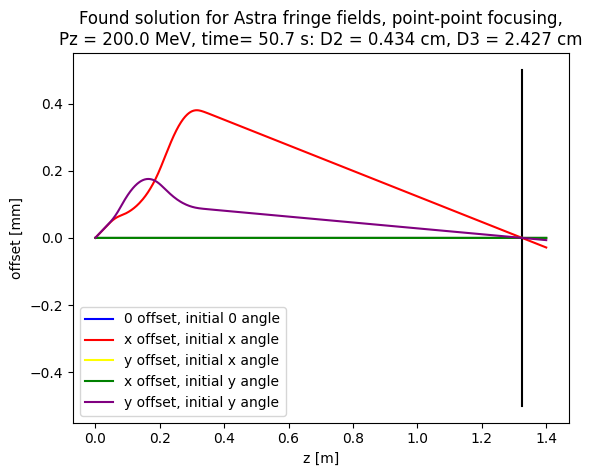

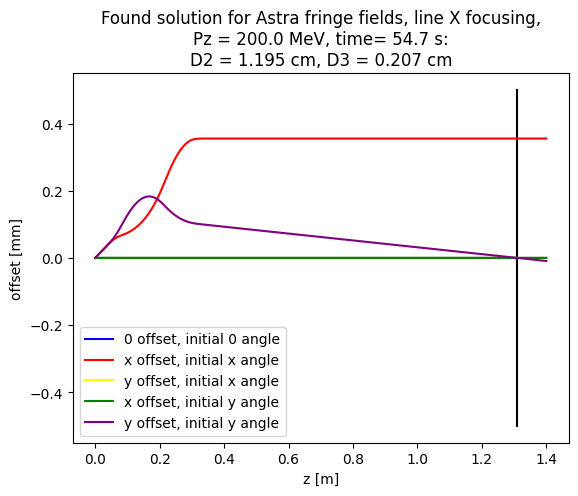

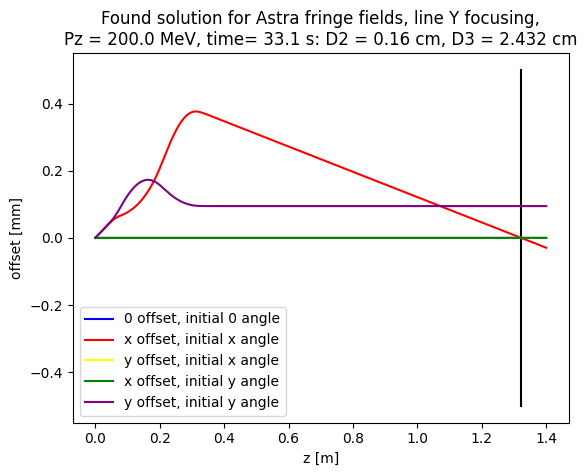

Timing with fields Astra fringe fields: the entire process for setup: [0.04, 0.00716, 0.000302, 1.0, 200000000.0] took 33.06279635429382 s


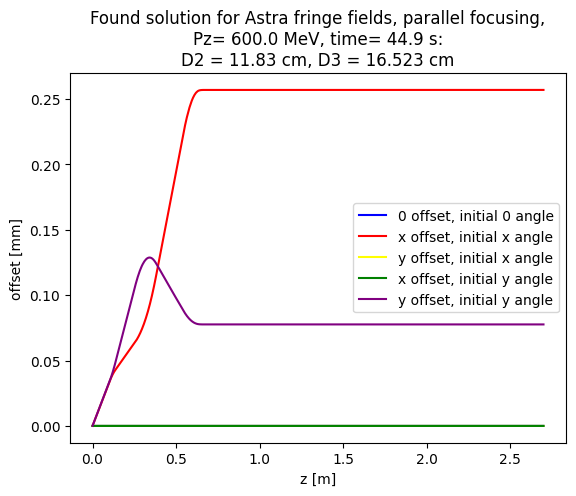

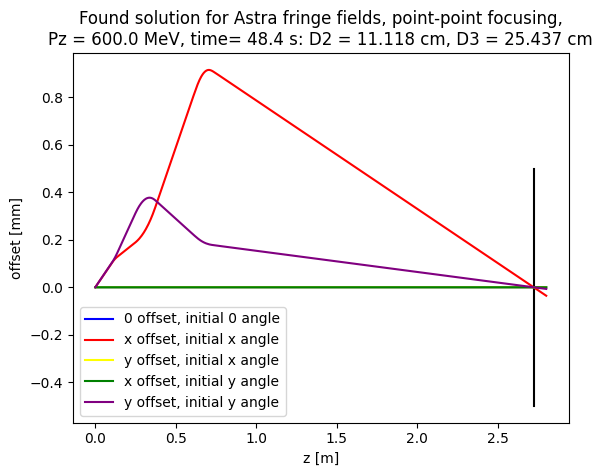

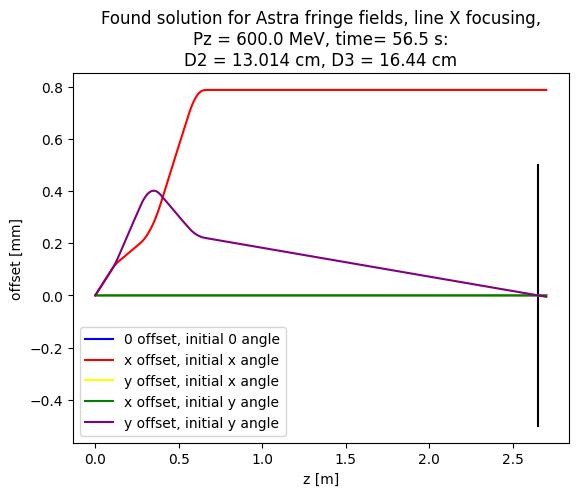

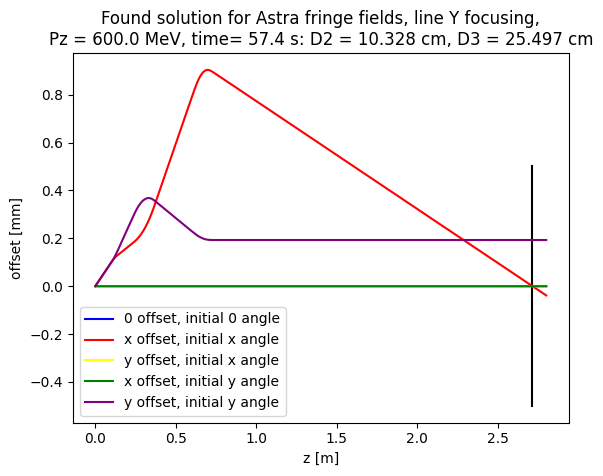

Timing with fields Astra fringe fields: the entire process for setup: [0.1, 0.1173, 0.163348, 2.0, 600000000.0] took 57.337730884552 s


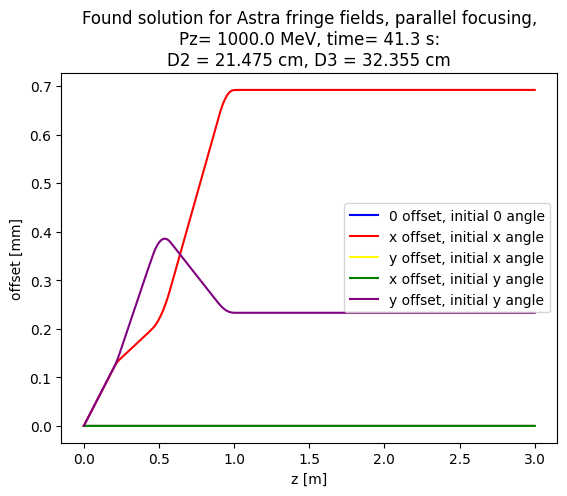

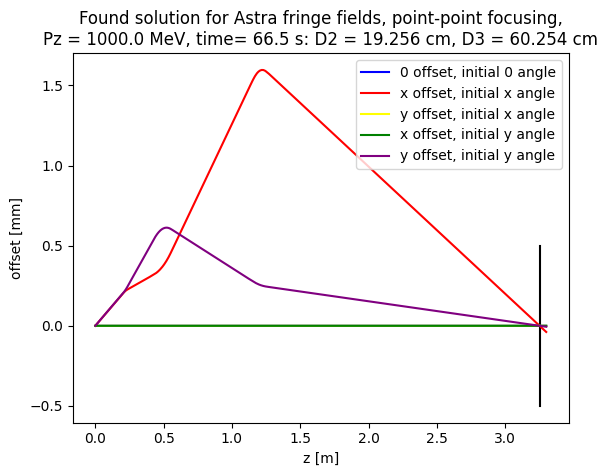

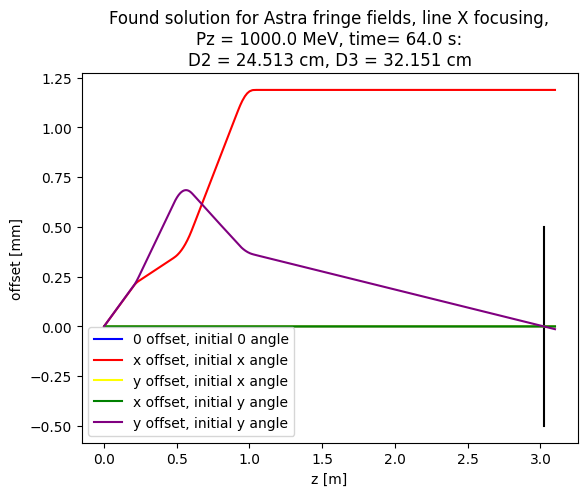

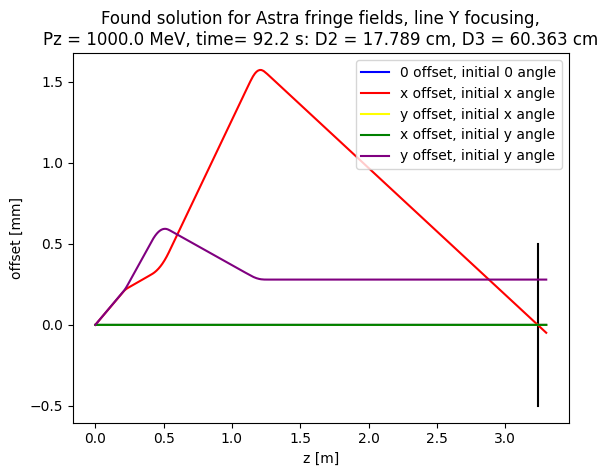

Timing with fields Astra fringe fields: the entire process for setup: [0.2, 0.213766, 0.321644, 2.0, 1000000000.0] took 92.14093017578125 s


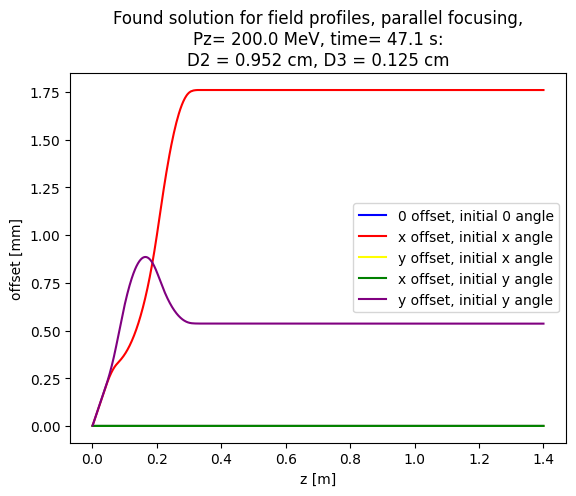

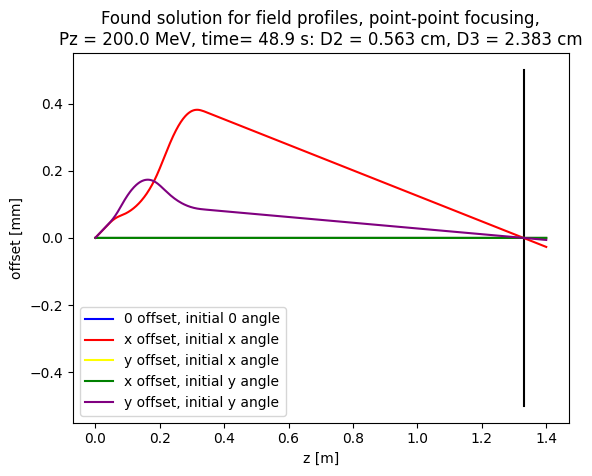

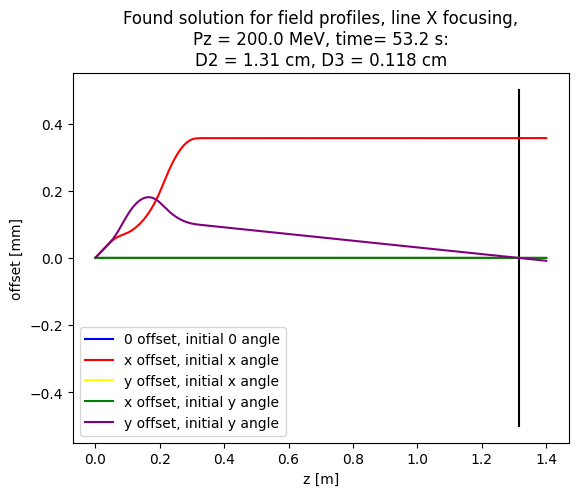

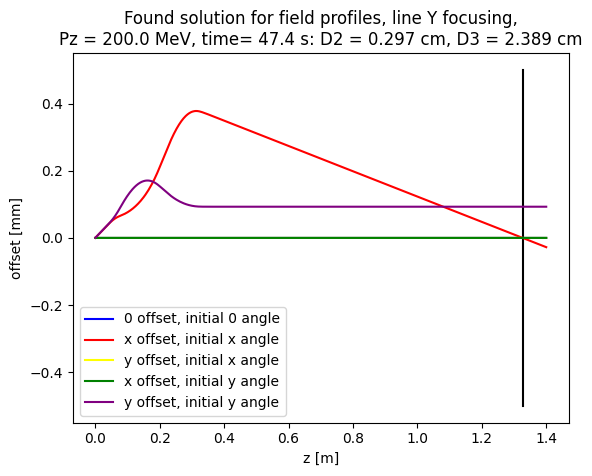

Timing with fields field profiles: the entire process for setup: [0.04, 0.00716, 0.000302, 1.0, 200000000.0] took 47.39713478088379 s


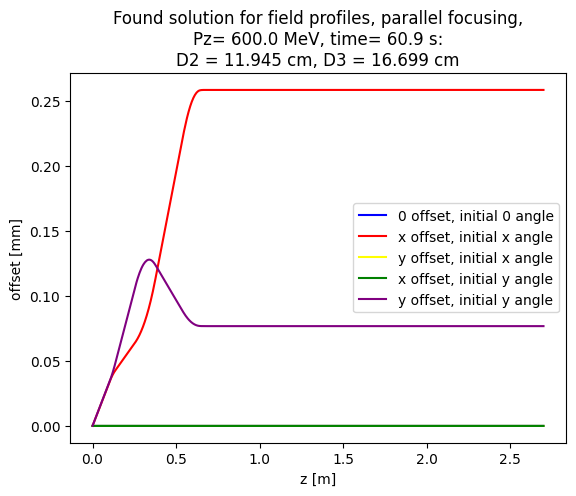

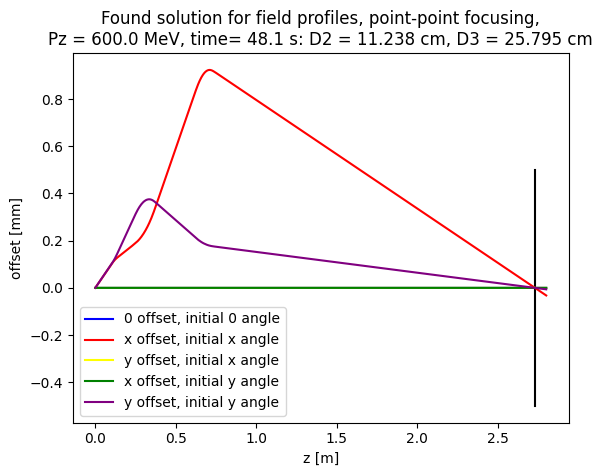

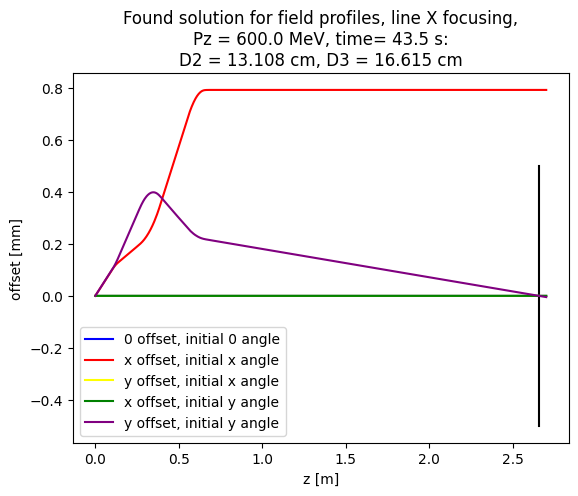

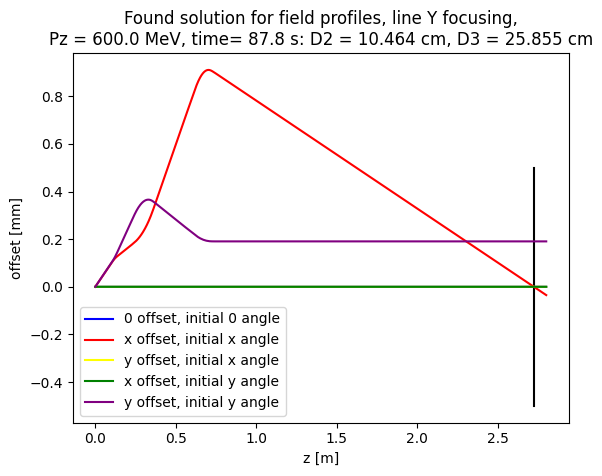

Timing with fields field profiles: the entire process for setup: [0.1, 0.1173, 0.163348, 2.0, 600000000.0] took 87.76079511642456 s


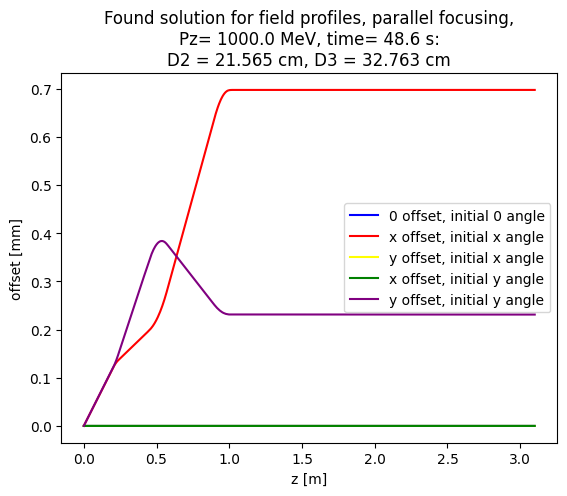

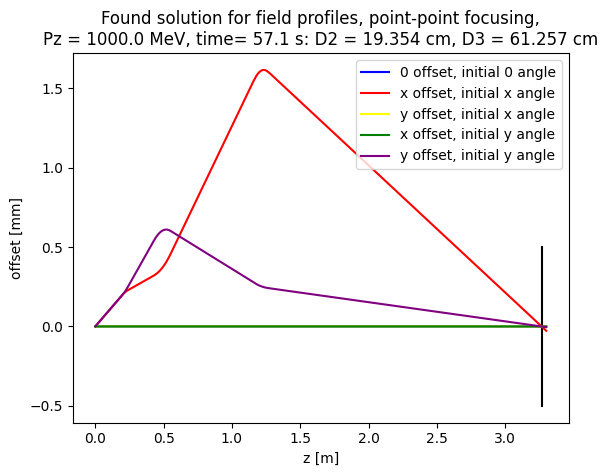

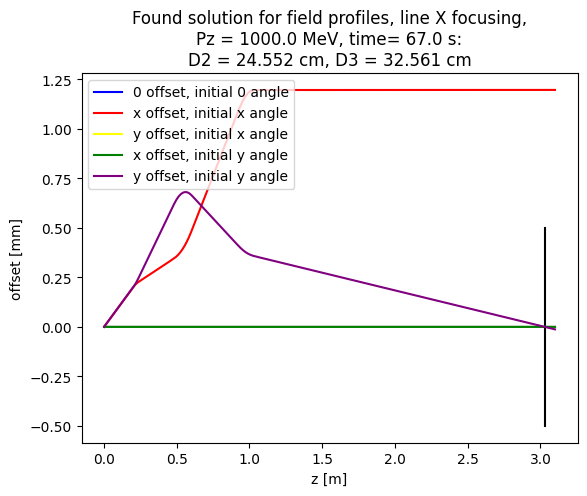

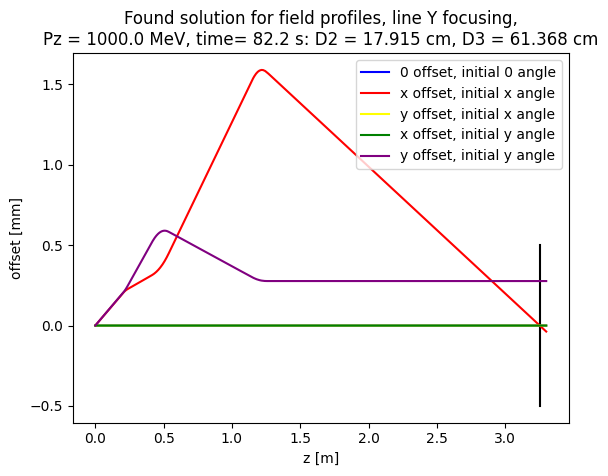

Timing with fields field profiles: the entire process for setup: [0.2, 0.213766, 0.321644, 2.0, 1000000000.0] took 82.17221713066101 s


In [99]:

proc = subprocess.Popen(
    ['/bin/bash'], 
    stdin=subprocess.PIPE, 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE, 
    text=True
)

proc.stdin.write("source /opt/intel/oneapi/setvars.sh\n")
proc.stdin.flush()

runAstra("../../MAXIMA/inputForTable.txt")
#print(findInfo(0.1,0.2,0.3,0.4, 5E+8))

proc.stdin.write("exit\n")
proc.stdin.flush()

#function([0.2,0.3], 0.1, 2E+8, "parallel")
#plotRefXY(0.04, 0.00716, 0.000302, None, 200000000.0)

Found solution for fields of type 0 for parallel focusing: [0.00720827 0.00031589]


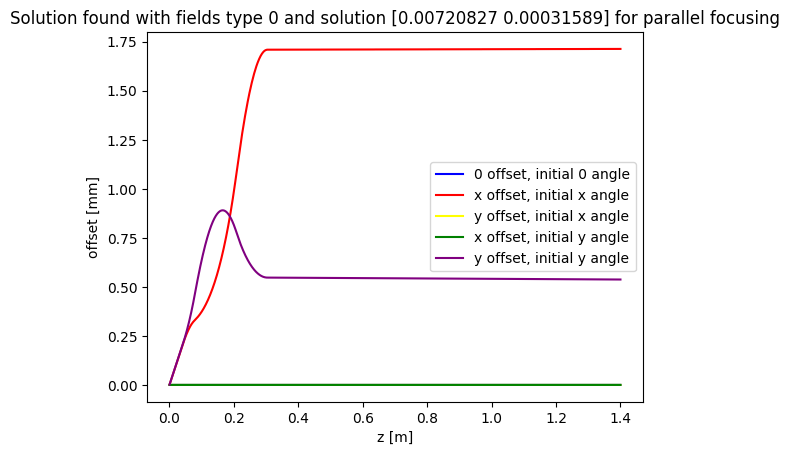

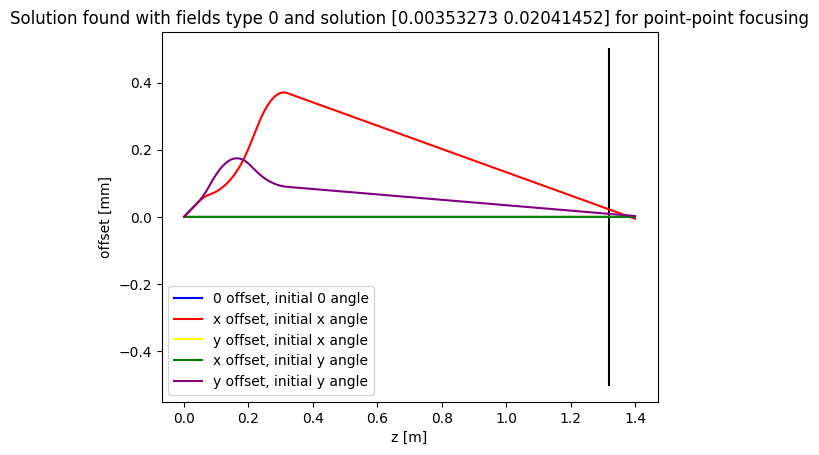

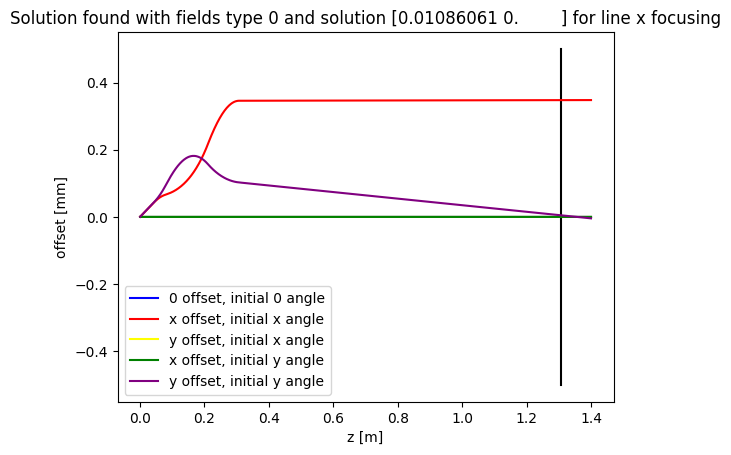

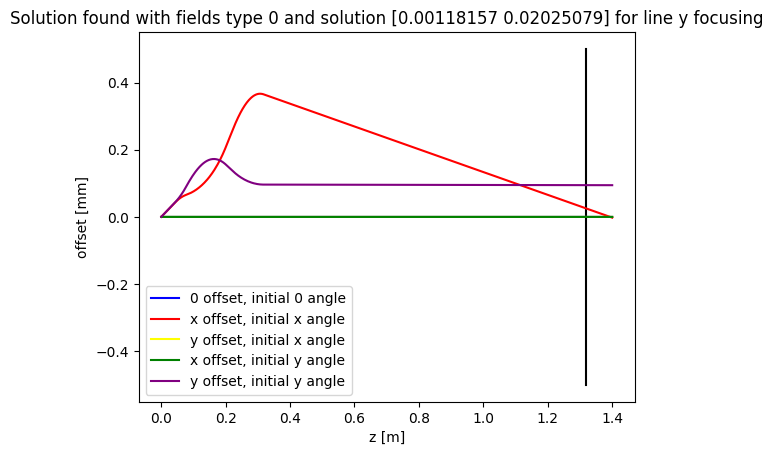

Timing with fields 0: the entire process for setup: [0.04, 0.00716, 0.000302, 1.0, 200000000.0] took 29.171228408813477 s
Found solution for fields of type 0 for parallel focusing: [0.11765621 0.16339569]


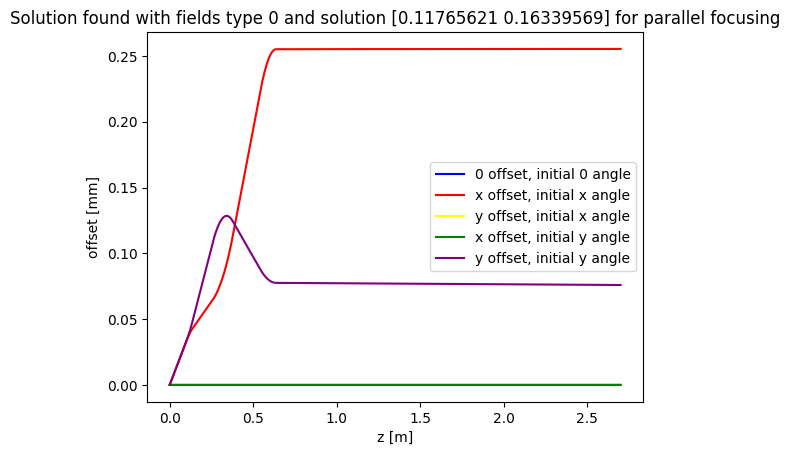

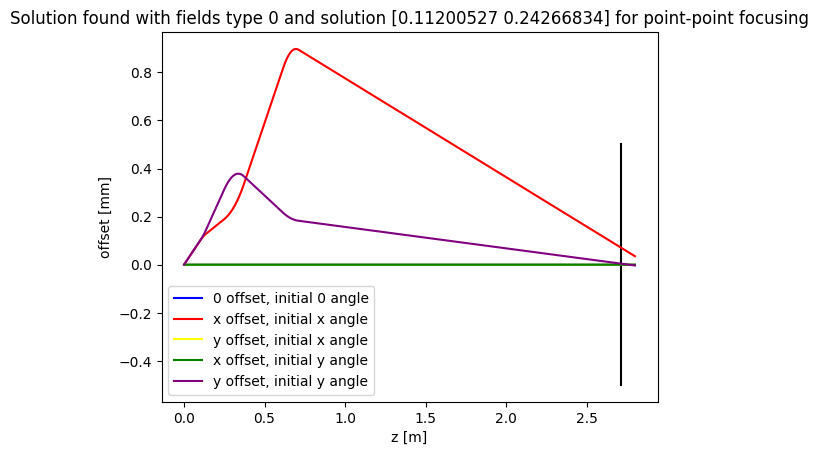

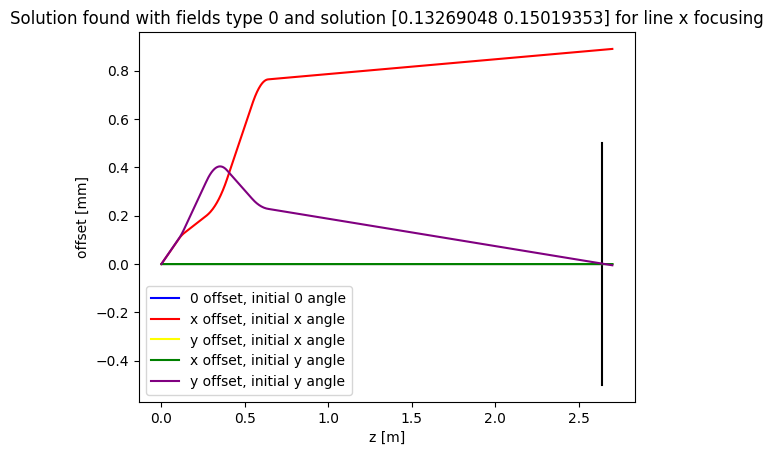

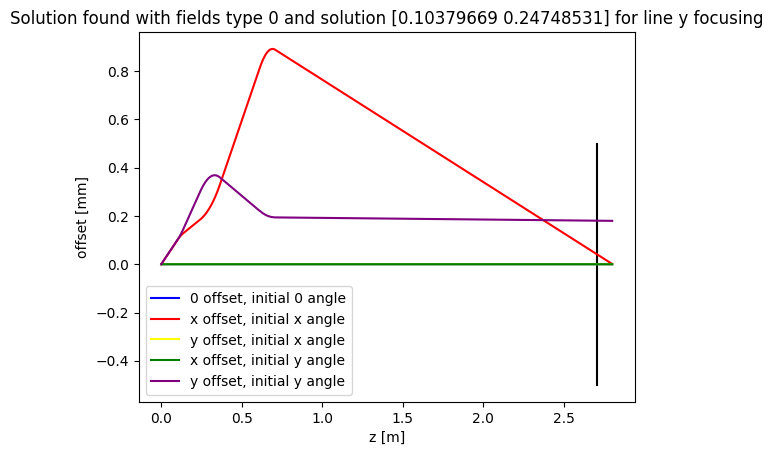

Timing with fields 0: the entire process for setup: [0.1, 0.1173, 0.163348, 2.0, 600000000.0] took 53.24535083770752 s
Found solution for fields of type 0 for parallel focusing: [0.21324038 0.32482099]


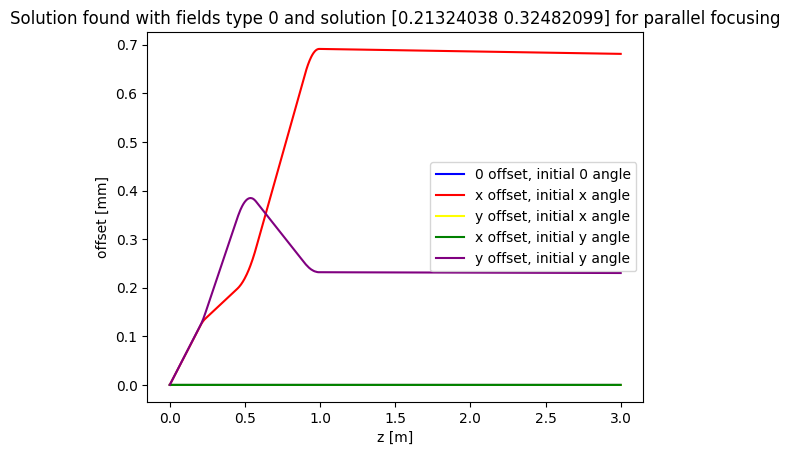

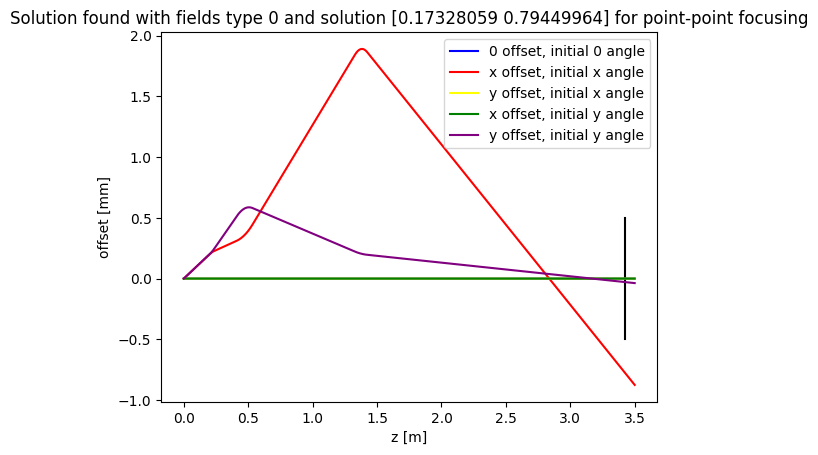

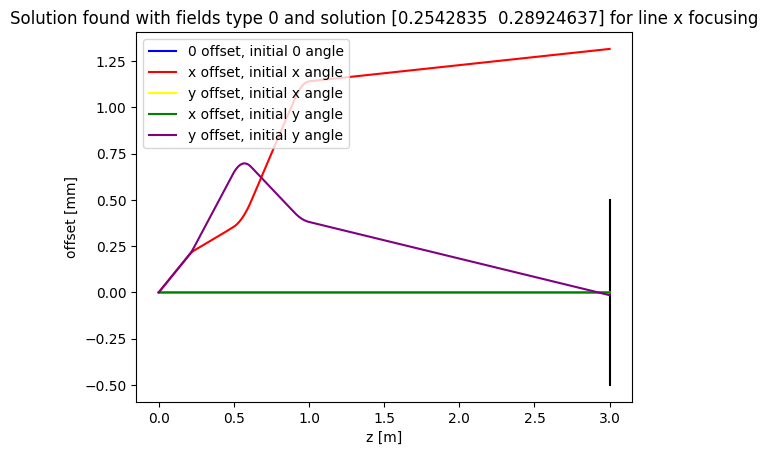

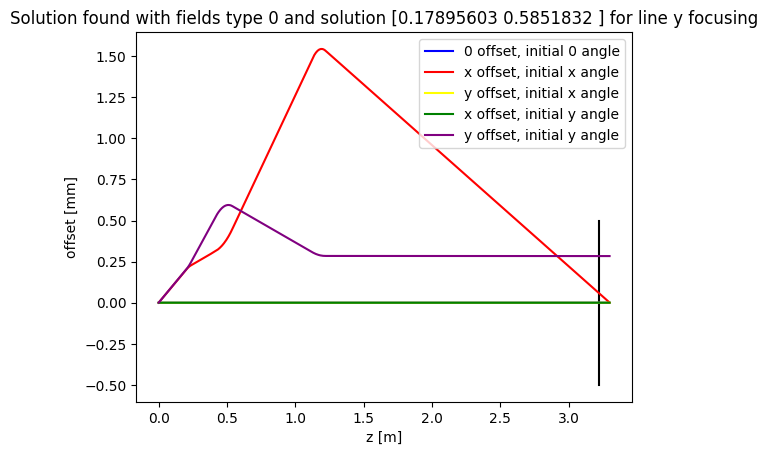

Timing with fields 0: the entire process for setup: [0.2, 0.213766, 0.321644, 2.0, 1000000000.0] took 70.93018651008606 s
Found solution for fields of type 1 for parallel focusing: [0.00825397 0.00212764]


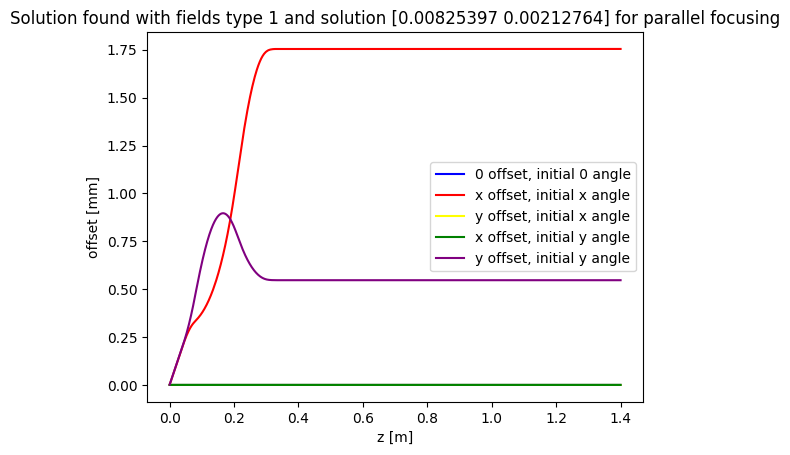

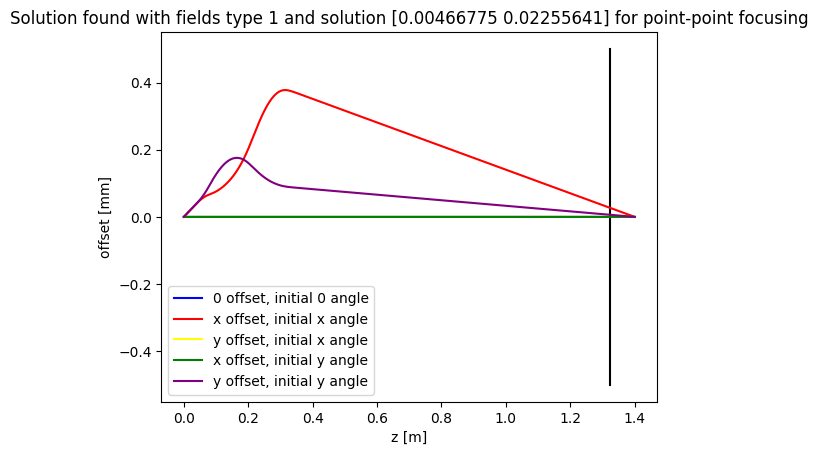

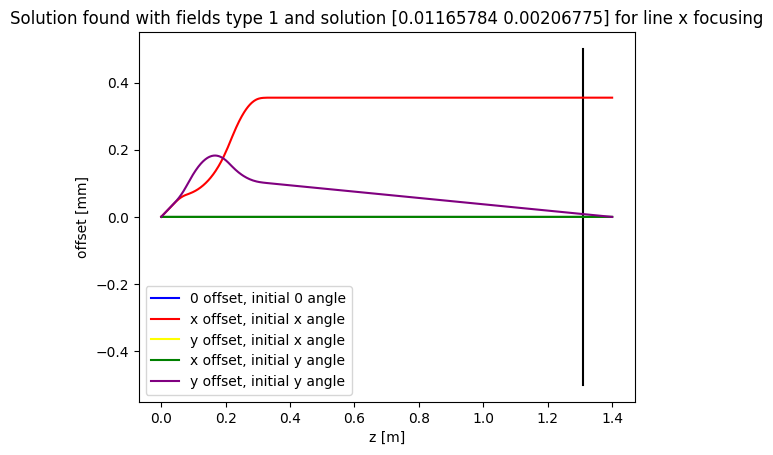

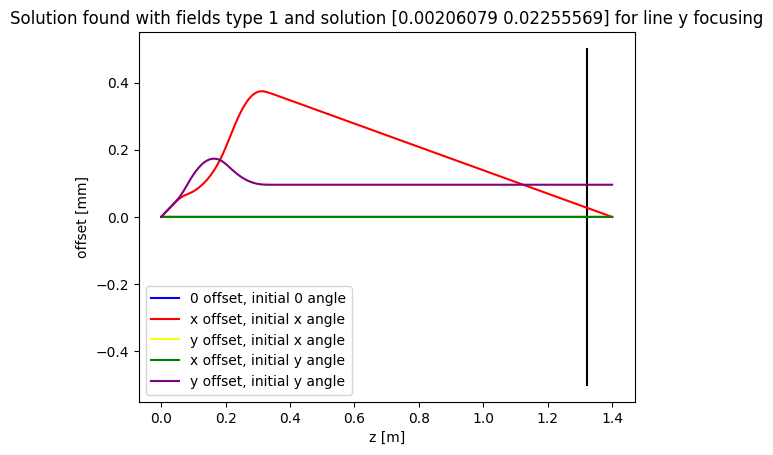

Timing with fields 1: the entire process for setup: [0.04, 0.00716, 0.000302, 1.0, 200000000.0] took 37.43583965301514 s
Found solution for fields of type 1 for parallel focusing: [0.11829694 0.1652223 ]


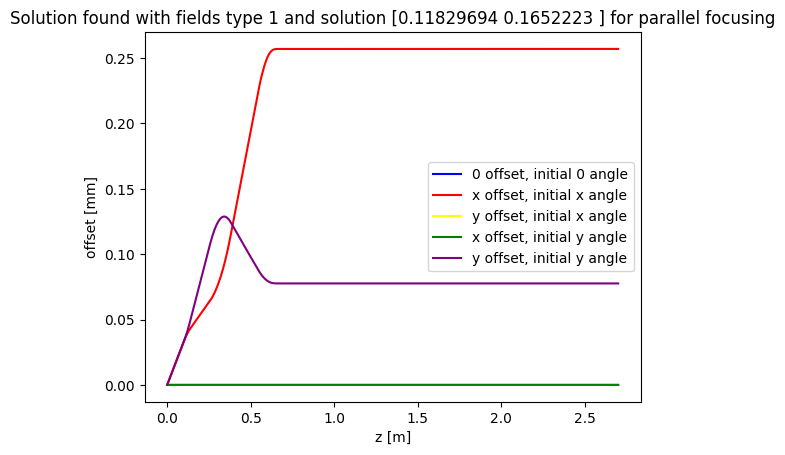

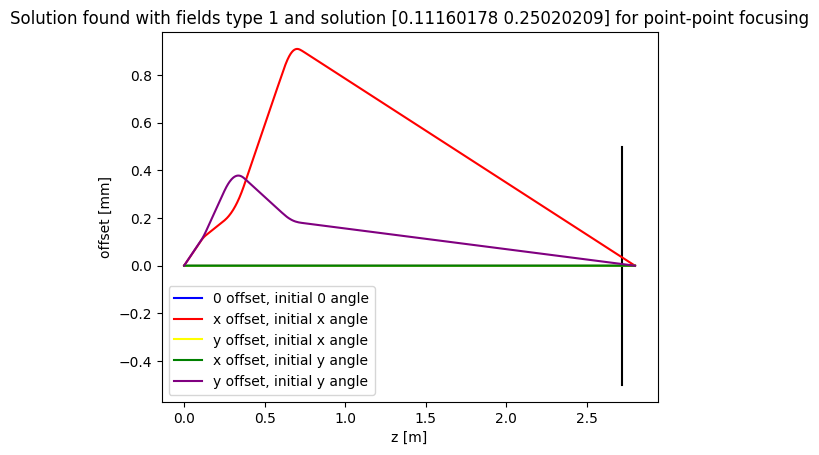

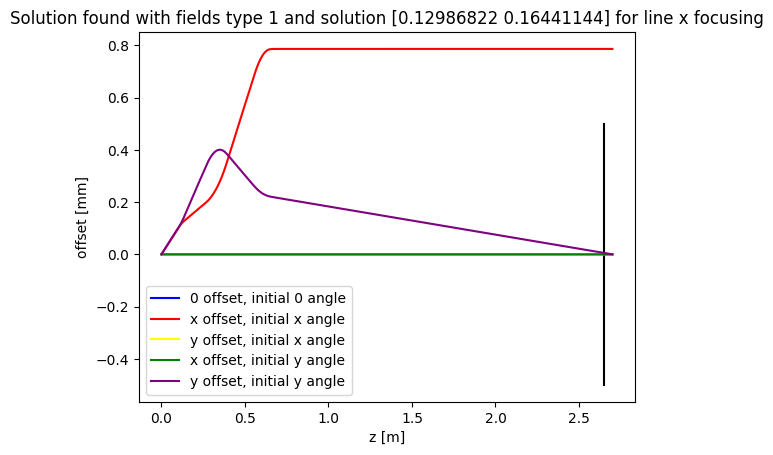

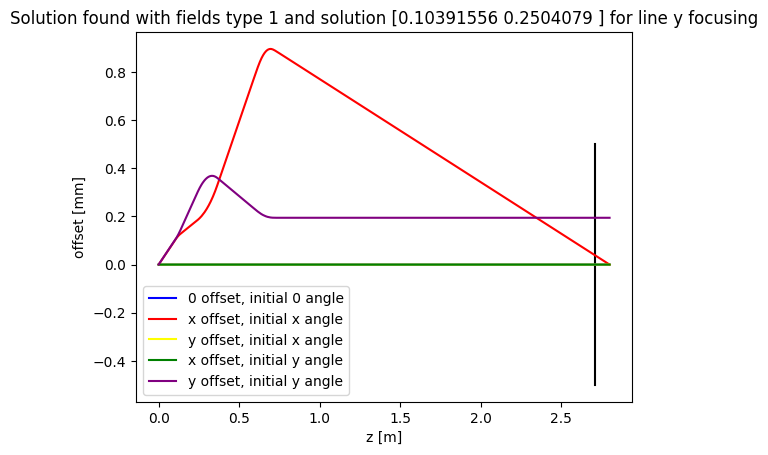

Timing with fields 1: the entire process for setup: [0.1, 0.1173, 0.163348, 2.0, 600000000.0] took 88.9021897315979 s
Found solution for fields of type 1 for parallel focusing: [0.21474521 0.32354118]


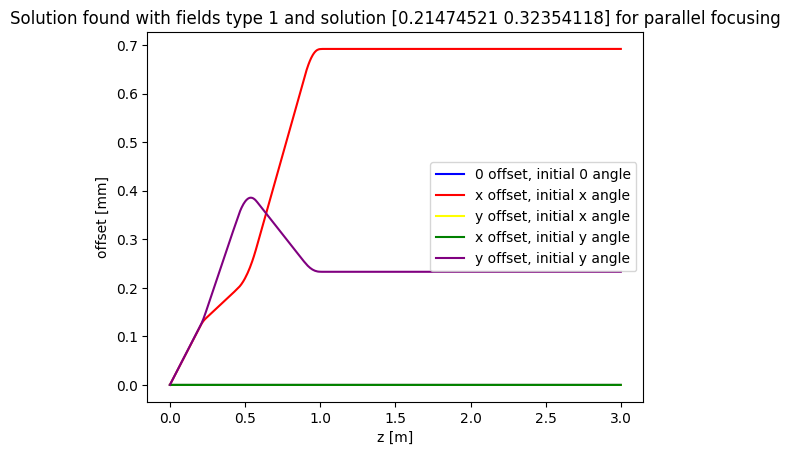

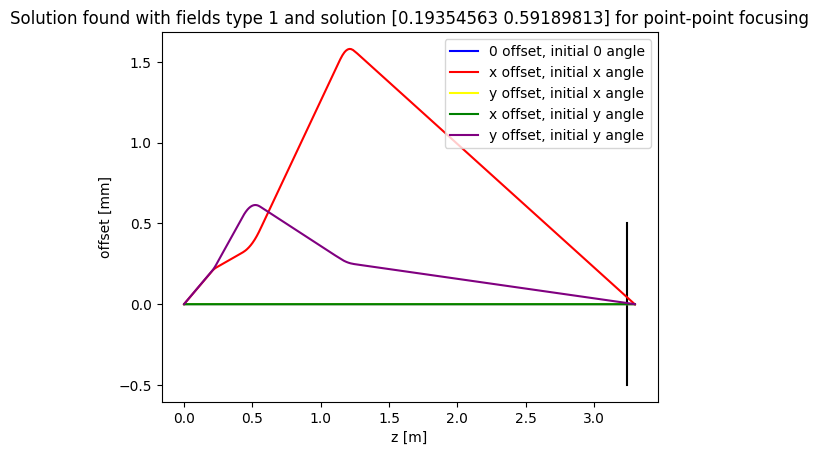

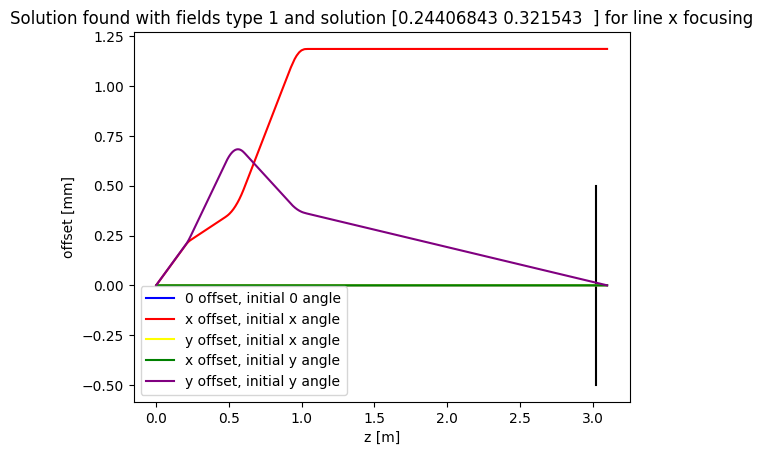

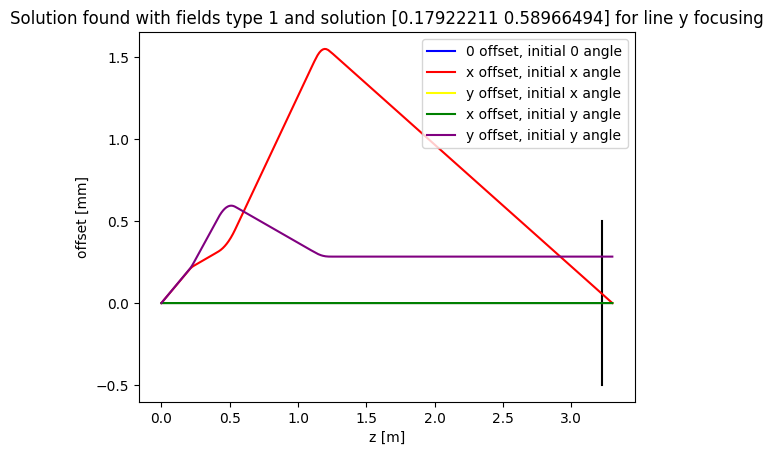

Timing with fields 1: the entire process for setup: [0.2, 0.213766, 0.321644, 2.0, 1000000000.0] took 164.33834624290466 s
Found solution for fields of type 2 for parallel focusing: [0.00953051 0.00123634]


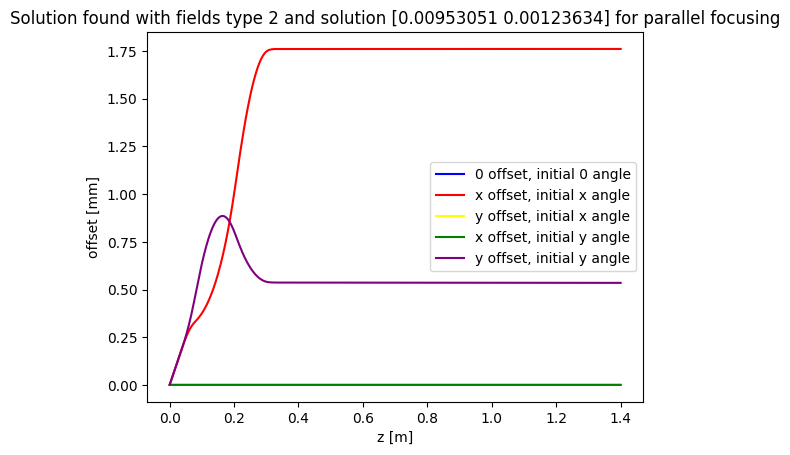

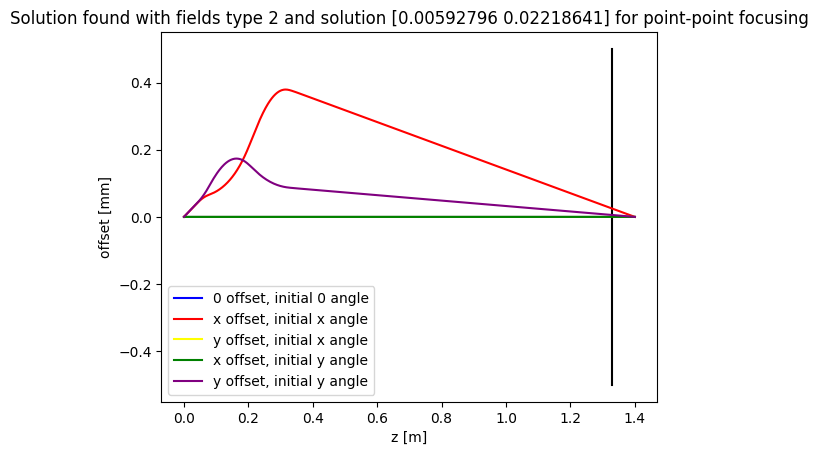

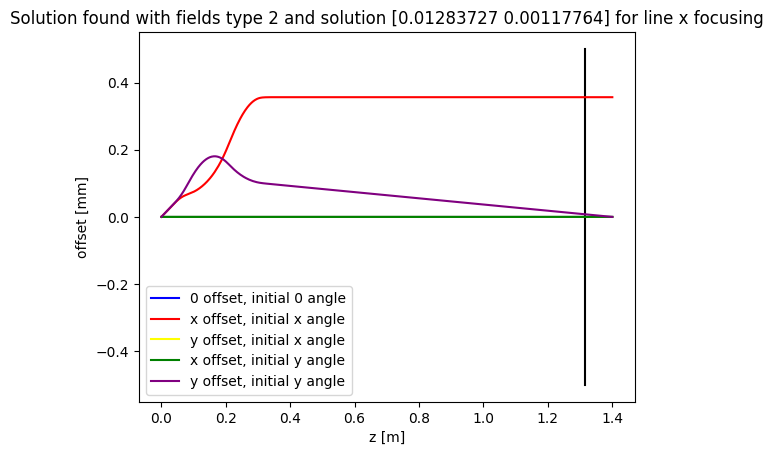

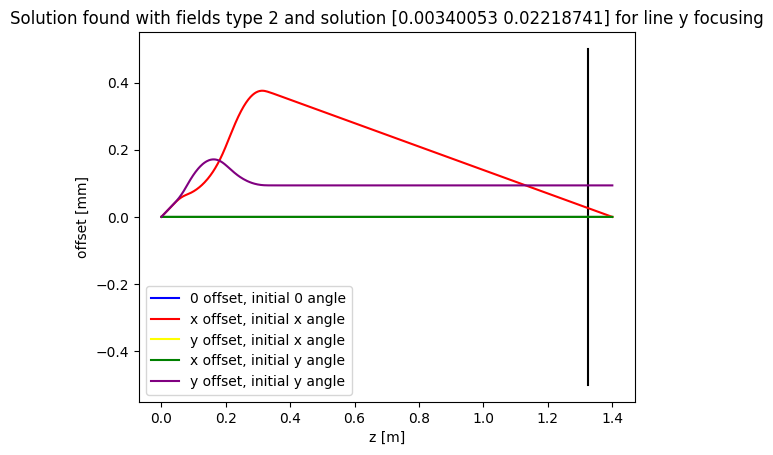

Timing with fields 2: the entire process for setup: [0.04, 0.00716, 0.000302, 1.0, 200000000.0] took 36.18420100212097 s
Found solution for fields of type 2 for parallel focusing: [0.11944933 0.1669805 ]


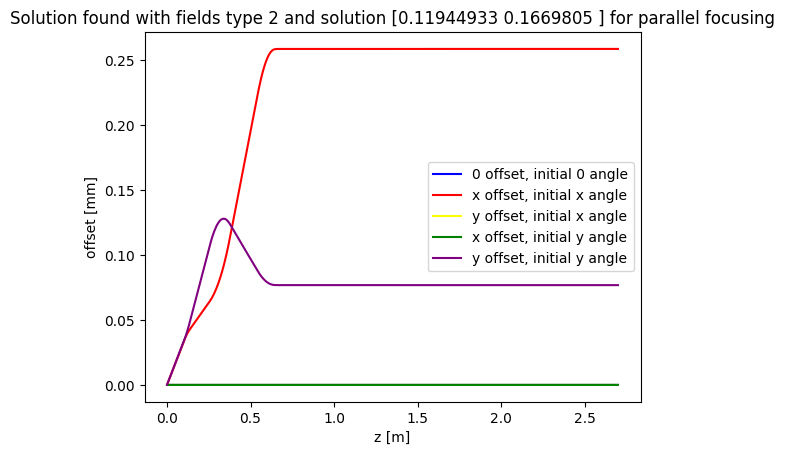

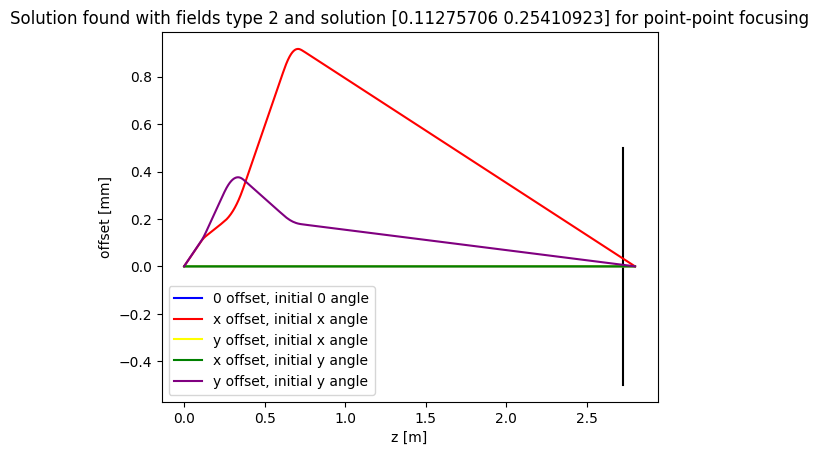

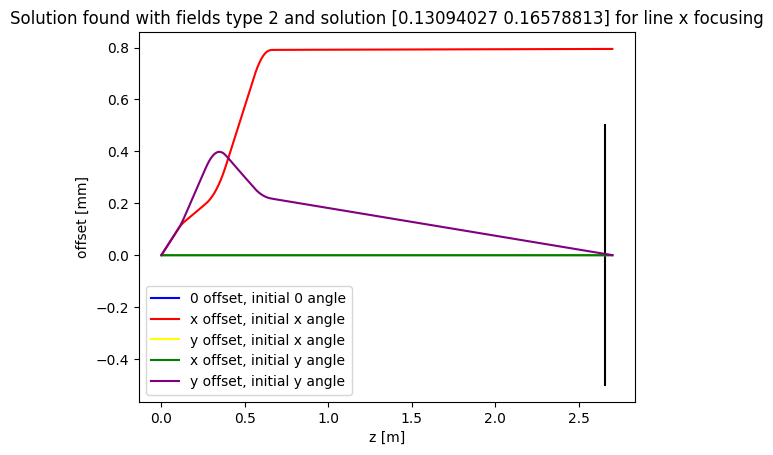

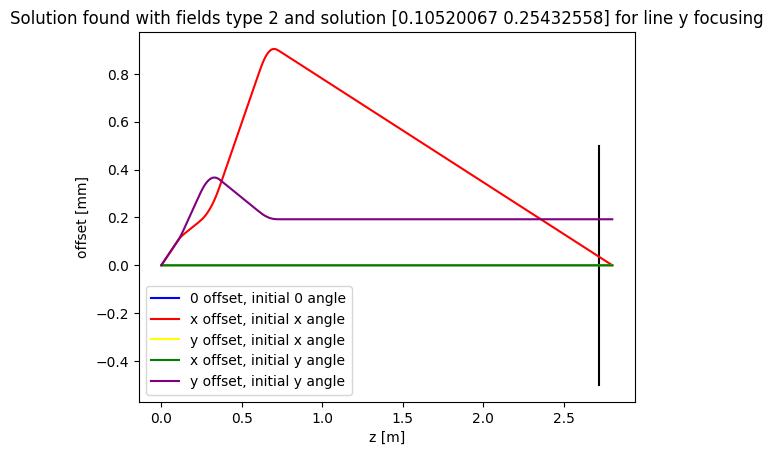

Timing with fields 2: the entire process for setup: [0.1, 0.1173, 0.163348, 2.0, 600000000.0] took 72.24105882644653 s
Found solution for fields of type 2 for parallel focusing: [0.21562541 0.3276665 ]


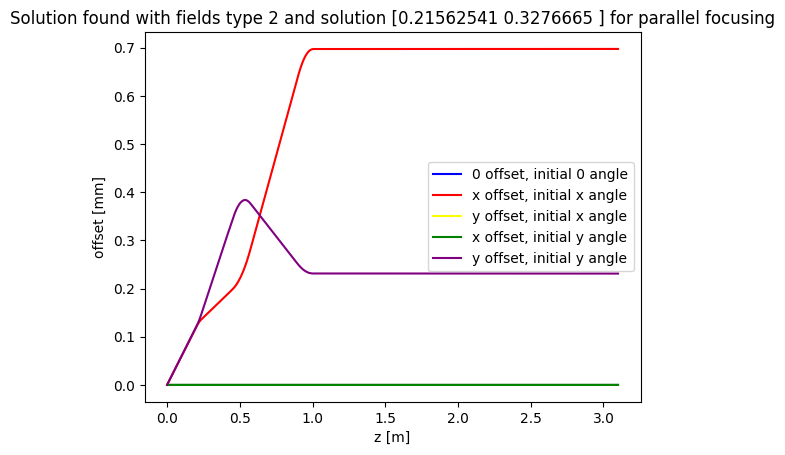

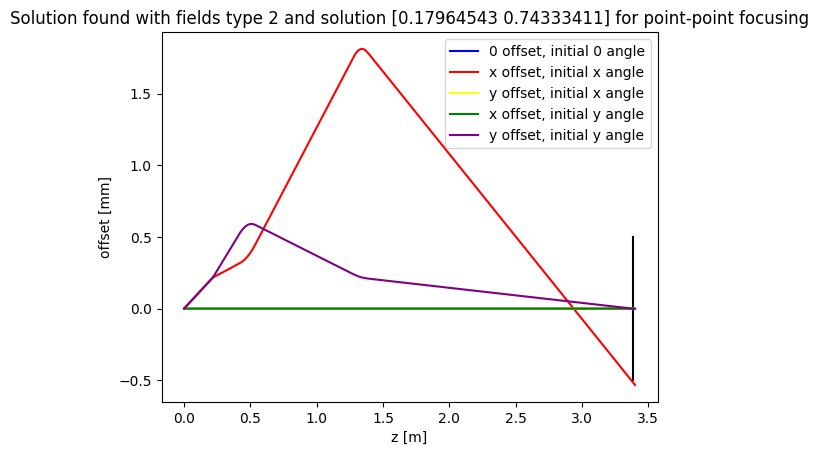

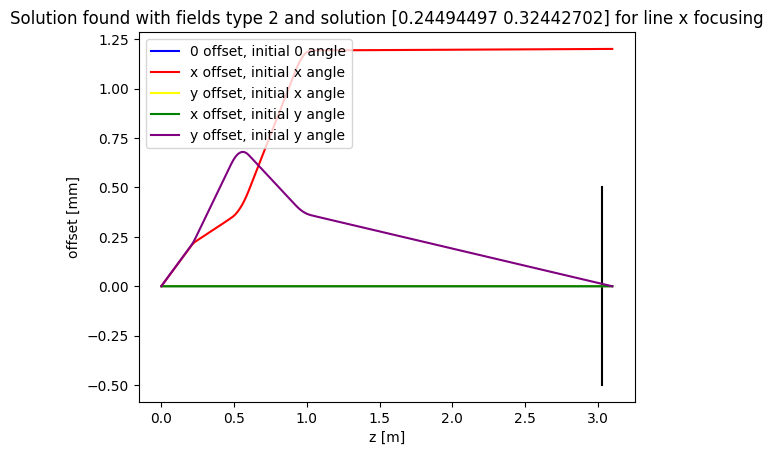

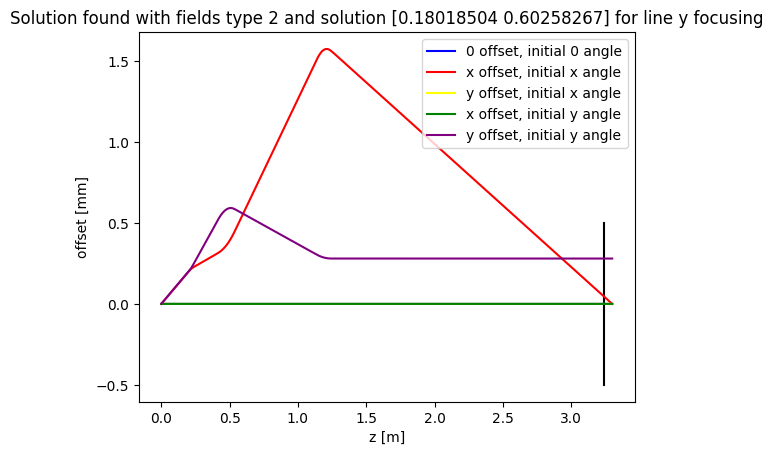

Timing with fields 2: the entire process for setup: [0.2, 0.213766, 0.321644, 2.0, 1000000000.0] took 129.53833603858948 s


In [238]:

proc = subprocess.Popen(
    ['/bin/bash'], 
    stdin=subprocess.PIPE, 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE, 
    text=True
)

proc.stdin.write("source /opt/intel/oneapi/setvars.sh\n")
proc.stdin.flush()

runAstra("../../MAXIMA/inputForTable.txt")

proc.stdin.write("exit\n")
proc.stdin.flush()

#function([0.2,0.3], 0.1, 2E+8, "parallel")
#plotRefXY(0.04, 0.00716, 0.000302, None, 200000000.0)

In [60]:
df = pd.read_csv("topHatFields.csv")
df

E [MeV]   D1 [cm]   D4 [cm]    D2 [cm]    D3 [cm]   L_tot [m]  \
0     200.0       4.0       0.0   0.720827   0.031589    1.303964   
1     200.0       4.0     100.0   0.353273   2.041452    1.320387   
2     200.0       4.0     100.0   1.086061   0.000000    1.307301   
3     200.0       4.0     100.0   0.118157   2.025079    1.317872   
4     600.0      10.0       0.0  11.697937  16.414537    2.637565   
5     600.0      10.0     200.0  11.823596  23.808106    2.712757   
6     600.0      10.0     200.0  12.925133  16.111471    2.646806   
7     600.0      10.0     200.0  10.295033  24.774044    2.707131   
8    1000.0      20.0       0.0  21.303992  32.155134    2.991031   
9    1000.0      20.0     200.0  19.359454  58.673180    3.236766   
10   1000.0      20.0     200.0  24.369302  31.833607    3.018469   
11   1000.0      20.0     200.0  17.881304  58.502465    3.220278   

     acc_x [mrad]   acc_y [mrad]   x_2/x'_1 [mm/mrad]   y_2/y'_1 [mm/mrad]  \
0       41.928721      39.827037             0.342680             0.107502   
1       40.486923      39.827037            -0.005344             0.002688   
2       41.385019      39.827037             0.347760            -0.004271   
3       40.907603      39.827037            -0.002129             0.094436   
4       19.561560      23.409457             0.760140             0.227090   
5       16.671112      23.305194             0.069986            -0.137750   
6       19.247796      22.519141             0.788990            -0.005973   
7       16.836906      24.260068            -0.001300             0.201400   
8       13.074174      14.050206             1.149767             0.390183   
9        9.545021      14.279886             0.002213            -0.004337   
10      12.723726      13.177353             1.187500             0.001074   
11       9.714397      14.279886             0.002085             0.279550   

     x_2/x_1 [mm/mm]   y_2/y_1 [mm/mm]   x'_2/x'_1 [mrad/mrad]  \
0            -4.1180           -9.8670                0.000720   
1            -2.9165          -12.0650               -0.346375   
2            -4.2171          -10.6500                0.001840   
3            -2.9617          -11.3860               -0.339105   
4            -3.1347           -8.7538               -0.003235   
5            -2.3756          -11.6780               -0.396100   
6            -3.2158           -9.2864                0.004717   
7            -2.3579          -11.0010               -0.424617   
8            -2.0050           -4.9463                0.001210   
9            -1.3224           -8.2633               -0.755420   
10           -2.2078           -5.7096                0.004126   
11           -1.3563           -7.8605               -0.736480   

     y'_2/y'_1 [mrad/mrad]  
0                -0.001782  
1                -0.080430  
2                -0.097840  
3                -0.001637  
4                -0.002275  
5                -0.149940  
6                -0.110635  
7                 0.002873  
8                 0.001006  
9                -0.122970  
10               -0.174610  
11               -0.002065

In [53]:
df = pd.read_csv("AstraFringeFields.csv")
df

E [MeV]   D1 [cm]   D4 [cm]    D2 [cm]    D3 [cm]   L_tot [m]  \
0     200.0       4.0       0.0   0.825397   0.212764    1.306822   
1     200.0       4.0     100.0   0.466775   2.255641    1.323664   
2     200.0       4.0     100.0   1.165784   0.206775    1.310166   
3     200.0       4.0     100.0   0.206079   2.255569    1.321056   
4     600.0      10.0       0.0  11.829694  16.522230    2.639959   
5     600.0      10.0     200.0  11.160178  25.020209    2.718244   
6     600.0      10.0     200.0  12.986822  16.441144    2.650720   
7     600.0      10.0     200.0  10.391556  25.040790    2.710763   
8    1000.0      20.0       0.0  21.474521  32.354118    2.994726   
9    1000.0      20.0     200.0  19.354563  59.189813    3.241884   
10   1000.0      20.0     200.0  24.406843  32.154300    3.022051   
11   1000.0      20.0     200.0  17.922211  58.966494    3.225327   

     acc_x [mrad]   acc_y [mrad]   x_2/x'_1 [mm/mrad]   y_2/y'_1 [mm/mrad]  \
0       41.666667      39.881949             0.350840             0.109338   
1       39.724576      39.898316             0.000017             0.000036   
2       41.201245      39.874680             0.354940            -0.000024   
3       40.102663      39.919704            -0.000015             0.095812   
4       19.484062      23.297955             0.770910             0.232866   
5       16.496024      23.801338            -0.000050             0.000033   
6       19.094659      22.465740             0.786630             0.000017   
7       16.737522      24.255024            -0.000001             0.194520   
8       13.015184      14.001680             1.153433             0.388350   
9        9.491268      14.278138            -0.001419            -0.000010   
10      12.648621      13.173495             1.187000             0.000026   
11       9.665571      14.278138            -0.000007             0.283570   

     x_2/x_1 [mm/mm]   y_2/y_1 [mm/mm]   x'_2/x'_1 [mrad/mrad]  \
0            -4.0420           -9.8486               -0.000018   
1            -2.8463          -12.0950               -0.351320   
2            -4.1320          -10.6260               -0.000051   
3            -2.8803          -11.4110               -0.347195   
4            -3.1431           -8.6921                0.000011   
5            -2.2931          -11.5200               -0.436100   
6            -3.1993           -9.2716                0.000014   
7            -2.3350          -11.0250               -0.428267   
8            -2.0036           -4.9358               -0.000003   
9            -1.3089           -8.2804               -0.764460   
10           -2.1947           -5.7229                0.000098   
11           -1.3439           -7.8649               -0.744130   

     y'_2/y'_1 [mrad/mrad]  
0             5.289100e-08  
1            -8.264500e-02  
2            -9.413000e-02  
3             3.095450e-05  
4             2.304850e-06  
5            -8.678833e-02  
6            -1.078483e-01  
7            -1.409383e-05  
8            -3.348167e-06  
9            -1.207700e-01  
10           -1.747200e-01  
11            7.444300e-06

In [54]:
df = pd.read_csv("fieldProfiles.csv")
df

E [MeV]   D1 [cm]   D4 [cm]    D2 [cm]    D3 [cm]   L_tot [m]  \
0     200.0       4.0       0.0   0.953051   0.123634    1.307207   
1     200.0       4.0     100.0   0.592796   2.218641    1.324554   
2     200.0       4.0     100.0   1.283727   0.117764    1.310455   
3     200.0       4.0     100.0   0.340053   2.218741    1.322028   
4     600.0      10.0       0.0  11.944933  16.698050    2.642870   
5     600.0      10.0     200.0  11.275706  25.410923    2.723306   
6     600.0      10.0     200.0  13.094027  16.578813    2.653168   
7     600.0      10.0     200.0  10.520067  25.432558    2.715966   
8    1000.0      20.0       0.0  21.562541  32.766650    2.999732   
9    1000.0      20.0     200.0  17.964543  74.333411    3.379420   
10   1000.0      20.0     200.0  24.494497  32.442702    3.025812   
11   1000.0      20.0     200.0  18.018504  60.258267    3.239208   

     acc_x [mrad]   acc_y [mrad]   x_2/x'_1 [mm/mrad]   y_2/y'_1 [mm/mrad]  \
0       41.833225      40.253019         3.522200e-01             0.106984   
1       39.563222      40.267375        -7.965100e-07             0.000044   
2       41.324211      40.246539         3.563100e-01             0.000015   
3       39.935039      40.287306        -2.637300e-05             0.093831   
4       19.357836      23.440552         7.759200e-01             0.230430   
5       16.356083      23.950821         4.988600e-07             0.000019   
6       18.988544      22.602843         7.947100e-01             0.000113   
7       16.592003      24.374956         2.158800e-05             0.192230   
8       12.914335      14.067995         1.162417e+00             0.385183   
9        8.275862      14.319614        -5.325500e-01            -0.002003   
10      12.571237      13.232181         1.201800e+00            -0.000351   
11       9.532283      14.319614        -7.092200e-06             0.279920   

     x_2/x_1 [mm/mm]   y_2/y_1 [mm/mm]   x'_2/x'_1 [mrad/mrad]  \
0            -4.0004          -10.0740               -0.000016   
1            -2.8335          -12.3540               -0.352915   
2            -4.0872          -10.8370               -0.000023   
3            -2.8667          -11.6850               -0.348845   
4            -3.1090           -8.8005                0.000006   
5            -2.2684          -11.6550               -0.440833   
6            -3.1698           -9.3642                0.001797   
7            -2.3092          -11.1660               -0.433050   
8            -2.0615           -5.2477               -0.000009   
9            -1.0179           -9.5935               -1.151100   
10           -2.1718           -5.7625                0.003685   
11           -1.3168           -7.9555               -0.759440   

     y'_2/y'_1 [mrad/mrad]  
0                -0.000288  
1                -0.080905  
2                -0.092260  
3                 0.000003  
4                -0.000009  
5                -0.085795  
6                -0.106733  
7                 0.000002  
8                -0.000006  
9                -0.105120  
10               -0.173710  
11               -0.000008

# Beam analytics
Here are functions that do not run only on 3 reference particles, but run the whole beam. The beam has it's energy/momentum spread whether it is in the magnitude of longitudinal momentum or in transverse direction.

In [83]:
def updateBeam(x_off, sig_x, sig_px, y_off, sig_y, sig_py, sig_z, sig_pz , pz):
    #sig_xyz in mm, sig_pxy in eV, sig_pz in keV
    #if any value is equal to -1, it skips

    if x_off != -1:
        changeInputData("x_off", x_off)
    if sig_x != -1:
        changeInputData("sig_x", sig_x)
    if sig_px != -1:
        changeInputData("sig_px", sig_px)

    if y_off != -1:
        changeInputData("y_off", y_off)
    if sig_y != -1:
        changeInputData("sig_y", sig_y)
    if sig_py != -1:
        changeInputData("sig_py", sig_py)

    if sig_z != -1:
        changeInputData("sig_z", sig_z)
    if sig_pz != -1:
        changeInputData("sig_Ekin", sig_pz)
    if pz != -1:
        changeInputData("Ref_Ekin", pz*1E-6) #convert from eV to MeV
        
    subprocess.run("./generator " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )

    return    

In [84]:
def runBeam(D1,D2,D3, momZ, px_sig, py_sig, moreData):


    changePositions(D1,D2,D3)

    #here can modify spreads in x, y, z directions
    updateBeam(-1, -1, px_sig, -1, -1, py_sig, -1, -1 ,momZ )
    
    
    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    outputMoreData = []
    changeInputData("Distribution", fileName + ".ini" )
    
    res = subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )
    '''
    if res.returncode != 0:
        res = subprocess.run("./Astra " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )
    if res.returncode != 0:
        print(f"Astra returned with an error")
        return 1
    '''
    
    
    dataX = loadDataRef("Xemit")
    dataY = loadDataRef("Yemit")
    
    if moreData:
        return [dataX, dataY]
    else:
        return dataX[-1], dataY[-1]
        

In [85]:
def divergence(dataX, dataY):

    data = loadDataRef(setupLengthStr)

    p = 0
    for line in data:
        p += (line[3]/line[5])**2 + (line[4]/line[5])**2
        
    
    return math.sqrt(p)         

In [86]:
def funcBeam(D,D1, mom, sig_px, sig_py):

    data = runBeam( D1, D[0], D[1], mom, sig_px, sig_py, False)
    divSum = divergence(*data)

    return divSum

In [87]:
def Beam():
# function which each setup runs only once and looks at the outcome of all 
    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.3,0.3]
    
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    Pz = []
    D1 = []
    for i in range(1,10):
        Pz.append(1.5E+8 + 5E+7*i)
        D1.append(0.01*i)
    
    results = ""
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_num [mrad]", "xAngle_sig [mrad]", "yAngle_sig [mrad]", "active_particles [%]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1
    for pz in Pz:
        for d1 in D1:
            topHatShapedQuads(True)
            res = sc.optimize.minimize(funcBeam, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(d1, pz, sig_px, sig_py))
            if not res.success:
                results += str(d1) + " " + str(0) + " " + str(0) + " " + str(pz) + "\n"
                continue
            
            sumNum = divergence(*runBeam(d1, *res.x , pz, sig_px, sig_py,False ))
            plotBeam(d1,res.x[0], res.x[1], pz, sig_px, sig_py, f"Numerical solution, [{d1}, {res.x}, {pz}], top hat fields")
            
            results += str(d1) + " " + str(res.x[0]) + " " + str(res.x[1]) + " "  + str(pz) + "\n"
            row = [d1, *res.x, pz, sumNum, sig_px, sig_py, activeParticles()]
            
            df['setup ' + str(i)] = row
            
    i += 1


    with open("resFigs/results.txt","w") as file:
        file.write(results)
    
        
    
    return df
    

In [88]:
#df = Beam()
#df.to_csv('resFigs/table.csv', index=False)


In [89]:
def plotBeam(D1, D2, D3, momZ, px_sig, py_sig, title):
    #this function plots px over py of all particles in a beam

    dataX, dataY = runBeam(D1, D2, D3, momZ,px_sig, py_sig, True)

    x = []
    x_avr = []
    xz = []
    y = []
    y_avr = []
    yz = []
    for line in dataX:
        xz.append(line[0])
        x.append(line[3])
        x_avr.append(line[2])
        
    for line in dataY:
        yz.append(line[0])
        y.append(line[3])   
        y_avr.append(line[2])

    plt.plot(yz, y, label="y rms", color='red')
    #plt.plot(yz, y_avr,label='y avr [mm]', color='yellow')
    plt.plot(xz, x, label="x rms", color='blue')
    #plt.plot(xz, x_avr, label='x avr [mm]', color='green')
    
    plt.xlabel('z [m]')
    plt.ylabel('offset rms [mm]')
    plt.legend()
    plt.title(title)

    plt.show()
    
    return   


In [90]:
def comparisonAnaBeam(setupFilePath):
    #this function takes in solutions from analytical and numerical calculations 
    
    update()
    #boundaries for D2, D3    

    
    
    with open(setupFilePath + "/resultsAna.txt", "r") as file:
        stringdata = file.readlines()
    
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    with open(setupFilePath + "/resultsBeam.txt","r") as file:
        stringdata = file.readlines()

    beamData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        beamData.append(line)        
    
    if len(beamData) != len(analyticData):
        print(f"Length of beamData({len(beamData)}) is not equal to analyticData({len(analyticData)})")
        return

    
    DeltaD2 = []
    DeltaD3 = []
    D1 = []
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_ana [mrad]", "F_num [mrad]", "Delta D2 [mm]" , "Delta D3 [mm]", "xAngle_sig [mrad]", "yAngle_sig [mrad]", "active_particles [%]"]
    }

    df = pd.DataFrame(resultsTable)

    for i in range(1,9):
        if i == 0:
            continue
        #first run the analytical solution and show how it looks in Astra
        topHatShapedQuads(True)
        sumAna = divergence(*runBeam(float(analyticData[i][0]),float(analyticData[i][1]), float(analyticData[i][2]), float(analyticData[i][3]), sig_px, sig_py, False))
        plotBeam(float(analyticData[i][0]),float(analyticData[i][1]), float(analyticData[i][2]), float(analyticData[i][3]), sig_px, sig_py, f"Analytic results, {analyticData[i]} top hat fields")

        #res = sc.optimize.minimize(funcBeam, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-5, args=(float(row[0]), float(row[3]), sig_px, sig_py))
        #res = sc.optimize.minimize(funcBeam, (0.15, 0.15), method="Powell", bounds=bounds, options={'ftol': 1e-6}, args=(float(row[0]), float(row[3]), sig_px, sig_py))

        sumNum = divergence(*runBeam(float(beamData[i][0]),math.ceil(float(beamData[i][1])*1E+5)*1E-5,math.ceil(float(beamData[i][2])*1E+5)*1E-5, float(beamData[i][3]), sig_px, sig_py, False))
        plotBeam(float(beamData[i][0]),math.ceil(float(beamData[i][1])*1E+5)*1E-5,math.ceil(float(beamData[i][2])*1E+5)*1E-5, float(beamData[i][3]), sig_px, sig_py, f"Numerical results, {beamData[i]} top hat fields")
        
        analyticData[i].append(sumAna)
        analyticData[i].append(sumNum)
        analyticData[i].append(math.fabs(float(analyticData[i][1]) - float(beamData[i][1]) )*1000 )
        analyticData[i].append(math.fabs(float(analyticData[i][2]) - float(beamData[i][2]))*1000 )
        analyticData[i].append(sig_px/float(beamData[i][3]))
        analyticData[i].append(sig_py/float(beamData[i][3]))
        analyticData[i].append(activeParticles())

        D1.append(analyticData[i][0]*100)
        DeltaD2.append(math.fabs(float(analyticData[i][1]) - float(beamData[i][1]))*1000 )
        DeltaD3.append(math.fabs(float(analyticData[i][2]) - float(beamData[i][2]))*1000 )
        
        df['setup ' + str(i)] = analyticData[i]
        

    plt.scatter(D1, DeltaD2, label='Delta D2', color='blue')
    plt.scatter(D1, DeltaD3, label='Delta D3', color='red')

    plt.xlabel('D1 [cm]')
    plt.ylabel('delta [mm]')
    plt.yscale('log')
    plt.title(f"Plot of differences between Astra and Maxima")
    plt.legend()
    plt.show()        
    
    return df
